#**Experimental Exploration of the Power of Group Equivariant Convolutional Networks**

Equivariant neural networks are part of the broader topic of geometric deep learning, which is learning with data that has some underlying geometric relationships. Equivariance and symmetries in deep learning are important because they enhance robustness, reduce model complexity, improve data efficiency, aid interpretability, and ultimately lead to better performance.

In this project, I aim to replicate the methodology and experiments presented in the paper ["Group Equivariant Convolutional Networks"](https://arxiv.org/abs/1602.07576) by Cohen and Welling and extend it to new applications, particularly focusing on evaluating its effectiveness in enhancing robustness against adversarial attacks.



The main idea behind Group Equivariant Convolutional Networks is to leverage the concept of symmetry in data to improve the performance of CNNs. Traditional CNNs are effective in capturing local patterns in images, but they lack the ability to handle and exploit symmetries present in the data. G-CNNs address this limitation by explicitly modeling and exploiting the symmetries through group theory.



The project consists of the following sections:

1. Setup
2. Group Theory and Group Equivariant Convolution
3. Experiments on Rotated MNIST
4. Experiments on CIFAR-10
5. Experiments on Plant Leaves
6. Conclusions

The experiments in sections 2 and 3 are based on the work presented in the paper ["Group Equivariant Convolutional Networks"](https://arxiv.org/abs/1602.07576) by Cohen and Welling. In section 4, Group Equivariant CNNs will be trained and tested on a novel dataset, which includes some classes from the healthy classes of [PlantVillage](https://data.mendeley.com/datasets/tywbtsjrjv/1), the most popular dataset for plant diseases classification. The other classes were collected by me and are part of my dataset published on [Kaggle](https://www.kaggle.com/datasets/jessicafrabotta/plant-diseases-dataset-with-augmentation) (I used non-augmented classes). Additionally, in every section, will be performed tests on perturbed examples.





# **1. Setup**

In this section, all the necessary libraries and packages will be imported.

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1GqcRUZHR0GT4K4u3qy9zMH5YL2AdVv9i
!mkdir -p /content/dataset
!unzip -u /content/Plant_Leaves.zip -d /content/dataset

Downloading...
From (uriginal): https://drive.google.com/uc?id=1GqcRUZHR0GT4K4u3qy9zMH5YL2AdVv9i
From (redirected): https://drive.google.com/uc?id=1GqcRUZHR0GT4K4u3qy9zMH5YL2AdVv9i&confirm=t&uuid=0ee61b45-f76b-43c4-b682-32c7e62375a8
To: /content/Plant_Leaves.zip
100% 173M/173M [00:01<00:00, 141MB/s]
Archive:  /content/Plant_Leaves.zip


In [ ]:
import torch
from torchvision.datasets import ImageFolder
import torchvision
from torchvision import datasets
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from datetime import datetime
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
transform = transforms.Compose([
    transforms.Resize((33, 33)),
    transforms.ToTensor(),
])

dataset = ImageFolder(root="/content/dataset/Plant_Leaves", transform=transform)

# **2. Group Theory and Group Equivariant Convolution**

CNNs are famously equivariant with respect to translation. This means that shifting the image and then feeding
it through a number of layers is the same as feeding the
original image through the same layers and then shifting
the resulting feature maps. Arguably, this property played a pivotal role in the advent of deep learning, reducing the number of trainable parameters by orders of magnitude.

However, simple CNN are not equivariant to rotation and reflection operations. Let's explore a little bit of mathematics which explains how Group Equivariant Convolutional Networks work.


---



What is equivariance?

Formally, let's consider two sets of data, X and Y, with corresponding transformations T(X) and T(Y), where T represents a transformation function. In the case of equivariance, if a neural network maps elements from X to Y, the following relationship holds:

$$f(T(X)) = T(f(X))$$


The equation asserts that if we apply a transformation T to the input data first and then pass it through the model F, the result will be the same as passing the original input through the model F and then applying the transformation T to the output. In other words, the model's response to the transformed input is equivalent to the response obtained by transforming the model's output after processing the original input.

---



A group is a set G
 together with an operation ∗
 which acts on pairs of elements from G
. For G
 to qualify as a group, the operation must follow these four rules:



*   **Closure**: *a ∗ b ∈ G*
*   **Associativity**: *a ∗ (b ∗ c) = (a ∗ b) ∗ c*
*   **Identity Element**: there’s some element *e ∈ G* such that *a ∗ e = e ∗ a = a* for every *a ∈ G*
*   **Inverse Elements**: every *a ∈ G* has an inverse *a<sup>-1</sup>∈ G*, such that *a ∗ a <sup>-1</sup> = a<sup>-1</sup>∗ a = e*


One useful example of a group is the set of all invertible n × n
 matrices, with matrix multiplication as the group operation ∗
.


A familiar property of matrices which turns out to be true for all groups is the following:

*   *(a ∗ b) <sup>-1</sup> = b <sup>-1</sup> ∗ a <sup>-1</sup>*


It’s common to omit the ∗
 symbol, so instead of the above we can write: *(ab) <sup>-1</sup> = b<sup>-1</sup> a <sup>-1</sup>*



Any set of symmetries forms a group if we choose to use function composition for the group operation ∗.

The group p4 includes rotations about the origin by 90 degrees, as well as all the elements of T the group of all translations of Z<sup>2</sup>.
An element of this group is identified by a tuple  (h, w, r) , where *h , w ∈ Z*  are integer translations and  *r ∈ C4*.

C4 is a cyclic group with four elements, typically represented by the integers modulo 4: {0, 1, 2, 3}.



<img src="https://imgur.com/F1UFCxq.png" width="530"
     height="230">

Figure 1. A p4 feature map and its rotation by r.


<img src="https://imgur.com/IiJ2gnV.png" width="280"
     height="200">

Figure 2. Cayley Table of the group C4.



The product and inverse of C4 will be implemented in the following cell. They will be very useful in the subsequent steps.

In [ ]:
class GroupC4:
    def product(r: int, s: int) -> int:
        return (r + s) % 4

    def inverse(r: int) -> int:
        return (4 - r) % 4

 A group action is defined as a group G acting on a set X, denoted by the operation *(g, x) -> g.x*, where g is an element of G and x is an element of X.

An element in the group C4 represents a counter-clockwise rotation of the image x by 90 degree. The rotated image g.x (denoted as *g.x(p)*) is defined for each pixel p in the following way:

*  *(g.x) (p) := x (g<sup>-1</sup>.p)*


where *g<sup>-1</sup>.p* is the pixel in the original image x that is moved to the position p in the new image g.x after the rotation.

In [ ]:
def rotate(x: torch.Tensor, r: int) -> torch.Tensor:
  return x.rot90(r, dims=(-2, -1))

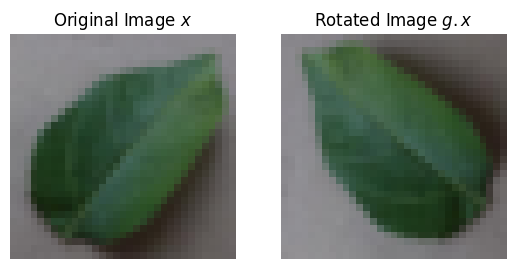

In [ ]:
index = 1
sample = dataset[index]

x, _ = sample

r = 1
gx = rotate(x, r)

plt.subplot(1, 2, 1)
plt.imshow(x.permute(1, 2, 0).numpy())
plt.title('Original Image $x$')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gx.permute(1, 2, 0).numpy())
plt.title('Rotated Image $g.x$')
plt.axis('off')

plt.show()

To visually prove that convolutional neural networks (CNNs) are not rotation equivariant, we will demonstrate how applying a rotation transformation before or after convolution completely changes the outcome. In the previous cell, two images were plotted from the Plant Leaves dataset: one is the original image, and the other is the same image rotated by 90 degrees. These two images will be used for the proof.

To begin, we feed the rotated image into a convolutional layer and then compare the result with the outcome of first convolving the original image and subsequently rotating it.

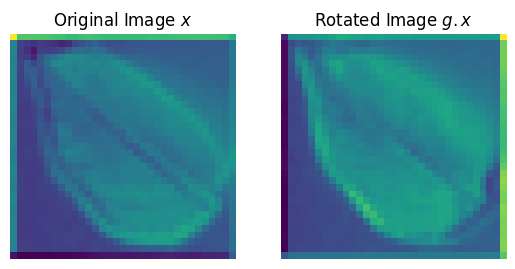

In [ ]:
filter3x3 = torch.randn(1, 3, 3, 3)

convolved_x = torch.conv2d(x, filter3x3, bias=None, padding=1)
convolved_gx = torch.conv2d(gx, filter3x3, bias=None, padding=1)

convolved_and_rotated_x = rotate(convolved_x, r)

plt.subplot(1, 2, 1)
plt.imshow(convolved_and_rotated_x.permute(1, 2, 0).numpy())
plt.title('Original Image $x$')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(convolved_gx.permute(1, 2, 0).numpy())
plt.title('Rotated Image $g.x$')
plt.axis('off')

plt.show()

The images may appear somewhat similar at first glance, but they are indeed distinct from each other:

In [ ]:
def are_images_equal(image1, image2):
    if image1.shape != image2.shape:
        return False
    equal_elements = torch.eq(image1, image2)
    all_equal = torch.all(equal_elements).item()
    return all_equal

print("Are the two images equal?", are_images_equal(convolved_and_rotated_x, convolved_gx))

Are the two images equal? False


Let  X  be again the space of grayscale images on a grid. Let now  *ψ ∈ X* be a filter and *x ∈ X* an input image.

The group convolution is defined as the sum of the product of ψ with the translated input image x, considering different transformations of the filter ψ. The output of the convolution is a function over the group p4, not a grayscale image. The space of all output signals is denoted as Y, which consists of functions on the group p4. Y is a G-space with a natural action of p4 on it.

Using a general filter ψ in group convolution maps the input space of images X into a larger space Y. This operation is sometimes also called a lifting convolution. A function y∈Y can be represented as a 4-channels image, with each channel corresponding to a different transformation of the filter ψ. This can be implemented by exploiting the usual torch.conv2d but by using  4  rotated copies of a single learnable filter.

We already observed how a group action operates. Now, let's proceed with implementing the group action on the space of functions over p4, i.e. over the pixel positions and over the elements of the group C_4 and then the lifting convolution:

In [ ]:
def rotate_p4(y: torch.Tensor, r: int) -> torch.Tensor:
  rotating_y = rotate(y, r)
  permuted_y = rotating_y.roll(r, dims=-3)
  return permuted_y

In [ ]:
class Lifting_Convolution_C4(torch.nn.Module):
  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, stride: int = 1, bias: bool = True):
    super(Lifting_Convolution_C4, self).__init__()

    self.kernel_size = kernel_size
    self.stride = stride
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels
    self.weight = None

    weight_shape = (self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)
    self.weight = nn.Parameter(torch.empty(*weight_shape))
    nn.init.normal_(self.weight, mean=0, std=1 / np.sqrt(self.out_channels * self.in_channels))

    self.bias = None
    if bias:
      self.bias = nn.Parameter(torch.Tensor(self.out_channels))
      nn.init.normal_(self.bias, mean=0, std=1 / np.sqrt(self.out_channels * self.in_channels))

  def build_filter(self) -> torch.Tensor:
    filter = None
    f_bias = None
    device = self.weight.device

    filter = torch.empty((self.out_channels, 4, self.in_channels, self.kernel_size, self.kernel_size), device=device)
    for i in range(4):
        filter[:, i, :, :, :] = rotate(self.weight, i)
    if self.bias is not None:
        f_bias = self.bias.unsqueeze(1).repeat(1, 4)
    else:
      f_bias = None
    return filter, f_bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    filter, f_bias = self.build_filter()
    filter = filter.reshape(self.out_channels * 4, self.in_channels, self.kernel_size, self.kernel_size)
    f_bias = f_bias.reshape(self.out_channels * 4)
    out = torch.conv2d(x, filter, stride=self.stride, padding=self.padding, dilation=self.dilation, bias=f_bias)
    return out.view(-1, self.out_channels, 4, out.shape[-2], out.shape[-1])

However, we cannot directly stack multiple layers to create a deep network because the output space of the layer is different from the input space. To address this issue, we define group convolution, which allows to perform convolution on functions over the group's elements (functions in Y, the space of functions over the group G, in this case p4).

By using the group convolution with a filter ψ in Y, we can map Y to Y, enabling the stacking of multiple layers for building a deep model.

In [ ]:
class Group_Convolution_p4(torch.nn.Module):
  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, stride: int = 1, bias: bool = True):
    super(Group_Convolution_p4, self).__init__()
    self.kernel_size = kernel_size
    self.stride = stride
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels
    self.weight = None

    weight_shape = (self.out_channels, self.in_channels, 4, self.kernel_size, self.kernel_size)
    self.weight = nn.Parameter(torch.empty(*weight_shape))
    nn.init.normal_(self.weight, mean=0, std=1 / np.sqrt(out_channels * in_channels))

    self.bias = None
    if bias:
      self.bias = nn.Parameter(torch.Tensor(out_channels))
      nn.init.normal_(self.bias, mean=0, std=1 / np.sqrt(out_channels * in_channels))

  def build_filter(self) ->torch.Tensor:
    filter = None
    f_bias = None
    filter = torch.empty((self.out_channels, 4, self.in_channels, 4, self.kernel_size, self.kernel_size), device=self.weight.device)
    for r in range(4):
      rotated_filter = rotate_p4(self.weight, r)
      filter[:, r, :, :, :, :] = rotated_filter

    if self.bias is not None:
      f_bias = self.bias.unsqueeze(1).repeat(1, 4)
    else:
      f_bias = None
    return filter, f_bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    filter, f_bias = self.build_filter()
    filter = filter.reshape(self.out_channels * 4, self.in_channels * 4, self.kernel_size, self.kernel_size)
    f_bias = f_bias.reshape(self.out_channels * 4)
    x = x.view(x.shape[0], self.in_channels*4, x.shape[-2], x.shape[-1])
    out = torch.conv2d(x, filter, stride=self.stride, padding=self.padding, dilation=self.dilation, bias=f_bias)
    return out.view(-1, self.out_channels, 4, out.shape[-2], out.shape[-1])

Batch normalization is a technique used in deep learning to address the internal covariate shift problem. It normalizes intermediate activations in each layer using mean and variance calculated over mini-batches. This process centers the activations around zero and scales them to have unit variance. Learnable parameters allow the model to adapt and retain the original representational power. Benefits include faster training, reduced sensitivity to hyperparameters, and improved generalization in neural network architectures.

This is an equivariant version of it:

In [ ]:
class EquivariantBatchNorm(nn.Module):
    def __init__(self, num_features, affine=True, eps=1e-5, momentum=0.1):
        super(EquivariantBatchNorm, self).__init__()
        self.batch_norm = nn.BatchNorm2d(num_features, affine=affine, eps=eps, momentum=momentum)

    def forward(self, input):
        x = input.view(input.size(0), input.size(1), -1, 1)
        x = self.batch_norm(x)
        x = x.view(input.size())
        return x



---

In their paper, Cohen and Welling explore another group, not just p4.

If we add a reflection operation to p4 (ensuring closure by including all compositions), we obtain another group called p4m.

Alternatively, we can define p4m like this: it is dihedral group D4 of rotations and reflections with the addition of translations.



The dihedral group D4 consists of 4 rotations and 4 reflections: the first four elements are rotations by 90 degrees (basically the elements of C4), and the last four are obtained by first applying a reflection F along the horizontal axis and then rotating by a multiple of 90 degrees.

Each element in D4 can be represented as a pair (f, r), where f = 0 or 1 represents whether a reflection is applied, and r = 0, 1, 2, or 3 represents the rotation.

<img src="https://imgur.com/h3lgZ60.png" width="530"
     height="230">

Figure 1. A p4m feature map and its rotation by r.


<img src="https://imgur.com/lT9NuFm.png" width="530"
     height="250">

Figure 2. Cayley Table of the group D4.

What does it mean to reflect an image?
Let's visualize it:

In [ ]:
def reflection(x: torch.Tensor) -> torch.Tensor:
  return torch.flip(x,[-2])

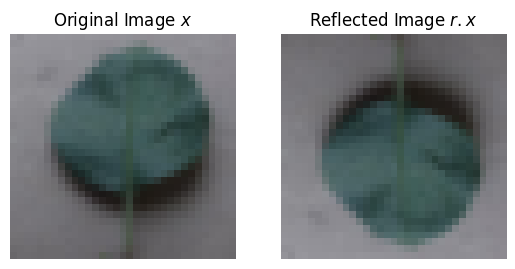

In [ ]:
index = 50
sample = dataset[index]

x, _ = sample

rx = reflection(x)

plt.subplot(1, 2, 1)
plt.imshow(x.permute(1, 2, 0).numpy())
plt.title('Original Image $x$')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rx.permute(1, 2, 0).numpy())
plt.title('Reflected Image $r.x$')
plt.axis('off')

plt.show()

The product and inverse of D4 will be implemented in the following cell.

In [ ]:
class GroupD4:

  def inverse(g: tuple) -> tuple:
    if not isinstance(g, tuple) or len(g) != 2 or g[0] not in [0, 1] or g[1] not in [0, 1, 2, 3]:
      raise ValueError("Invalid input element.")
    f, r = g
    r_inverted = GroupC4.inverse(r)
    if f == 0:
      return (0, r_inverted)
    else:
      return (1, r)

  def product(a: tuple, b: tuple) -> tuple:
    if not isinstance(a, tuple) or not isinstance(b, tuple):
        raise TypeError("Input elements must be tuples.")
    if len(a) != 2 or len(b) != 2:
        raise ValueError("Input tuples must have two elements each.")
    f1, r1 = a
    f2, r2 = b
    if f1 not in [0, 1] or f2 not in [0, 1] or r1 not in [0, 1, 2, 3] or r2 not in [0, 1, 2, 3]:
        raise ValueError("Invalid input elements.")
    f = 0
    r = 0
    g = (f, r)
    if f1 == 0 and f2 == 0:
        g = (0, GroupC4.product(r1, r2))
    elif f1 == 0 and f2 == 1:
      g = (1, GroupC4.product(r1, (r2 - 4)))
    elif f1 == 1 and f2 == 0:
      g = (1, GroupC4.product(r1, GroupC4.inverse(r2)))
    elif f1 == 1 and f2 == 1:
      g = (0, GroupC4.product((4 - r1), GroupC4.inverse(4 - r2)))
    return g

Now, following the steps already seen for p4, in the following cells will be implemented the group action on the space of functions over p4m, the lifting convolution for p4m and the group convolution for p4m.

In [ ]:
def rotoreflection_p4m(y: torch.Tensor, g: tuple) -> torch.Tensor:
  f, r = g
  rotated_y = torch.empty(y.shape)
  permuted_y = torch.empty(y.shape)
  if f == 0:
    rotated_y=rotate(y,r)
    for j in range(2):
      for i in range(4):
        index = GroupD4.product((f,r),(j,i))
        f1, r1 = index
        if j==0:
          permuted_y[...,r1,: ,:] = rotated_y[...,i,:,:]
        if j==1:
          permuted_y[...,r1+4,: ,:] = rotated_y[...,i+4,:,:]
  if f == 1:
    rotoreflected_y = reflection(rotate(y,4-r))
    for j in range(2):
      for i in range(4):
        index2 = GroupD4.inverse(GroupD4.product((f,r),(j,i)))
        f2, r2 = index2
        if j==0:
          permuted_y[...,r2,: ,:] = rotoreflected_y[...,i+4,:,:]
        if j==1:
          permuted_y[...,r2+4,: ,:] = rotoreflected_y[...,i,:,:]
  return permuted_y

Let's visualize how the function rotoreflection_p4m works. Additionally, we will demonstrate that its action is equivalent to performing a rotation and then a reflection of the images.

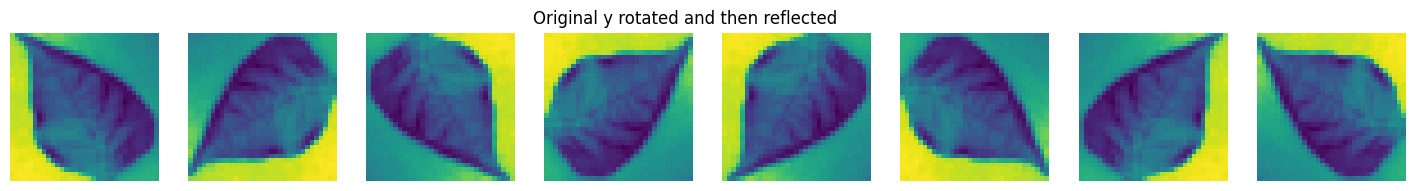

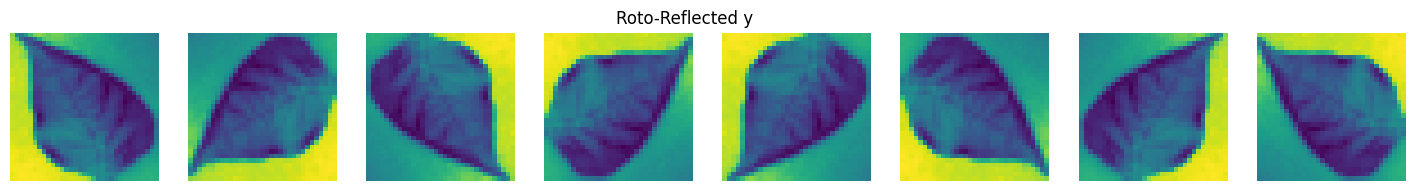

In [ ]:
x = dataset.__getitem__(7900)[0][0]
ref = reflection(x)
y = torch.stack((x, rotate(x, 1), rotate(x, 2), rotate(x, 3), ref, rotate(ref, 1), rotate(ref, 2), rotate(ref, 3)), dim=0)
roto_ref = rotoreflection_p4m(y,(0,0))

fig, axes = plt.subplots(1, 8, figsize=(18, 2))
for i in range(8):
    axes[i].imshow(y[i].numpy())
    axes[i].axis('off')
fig.suptitle('Original y rotated and then reflected')
plt.show()

fig, axes = plt.subplots(1, 8, figsize=(18, 2))
for i in range(8):
    axes[i].imshow(roto_ref[i].numpy())
    axes[i].axis('off')
fig.suptitle('Roto-Reflected y')
plt.show()

The index are permuted correctly by the rotoreflection_p4m function. Proof:

In [ ]:
def are_images_equal(image1, image2):
    if image1.shape != image2.shape:
        return False
    equal_elements = torch.eq(image1, image2)
    all_equal = torch.all(equal_elements).item()
    return all_equal

print("Are the images equal?", are_images_equal(y, roto_ref))

Are the images equal? True


In [ ]:
class Lifting_Convolution_D4(torch.nn.Module):
  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, stride: int = 1, bias: bool = True):
    super(Lifting_Convolution_D4, self).__init__()
    self.kernel_size = kernel_size
    self.stride = stride
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels
    self.weight = None

    weight_shape = (self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)
    self.weight = nn.Parameter(torch.empty(*weight_shape))
    nn.init.normal_(self.weight, mean=0, std=1 / np.sqrt(self.out_channels * self.in_channels))

    self.bias = None
    if bias:
      self.bias = nn.Parameter(torch.Tensor(self.out_channels))
      nn.init.normal_(self.bias, mean=0, std=1 / np.sqrt(self.out_channels * self.in_channels))

  def build_filter(self) -> torch.Tensor:
    filter = None
    f_bias = None
    device = self.weight.device
    filter = torch.empty((self.out_channels, 8, self.in_channels, self.kernel_size, self.kernel_size), device=device)
    for i in range(4):
        filter[:, i, :, :, :] = rotate(self.weight, i)
    for i in range(4,8):
        filter[:, i, :, :, :] = rotate(reflection(self.weight), i)

    if self.bias is not None:
        f_bias = self.bias.unsqueeze(1).repeat(1, 8)
    else:
      f_bias = None
    return filter, f_bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    filter, f_bias = self.build_filter()
    filter = filter.reshape(self.out_channels * 8, self.in_channels, self.kernel_size, self.kernel_size)
    f_bias = f_bias.reshape(self.out_channels * 8)

    out = torch.conv2d(x, filter, stride=self.stride, padding=self.padding, dilation=self.dilation, bias=f_bias)
    return out.view(-1, self.out_channels, 8, out.shape[-2], out.shape[-1])

In [ ]:
class Group_Convolution_p4m(torch.nn.Module):
  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, stride: int = 1, bias: bool = True):
    super(Group_Convolution_p4m, self).__init__()
    self.kernel_size = kernel_size
    self.stride = stride
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels
    self.weight = None

    weight_shape = (self.out_channels, self.in_channels, 8, self.kernel_size, self.kernel_size)
    self.weight = nn.Parameter(torch.empty(*weight_shape))
    nn.init.normal_(self.weight, mean=0, std=1 / np.sqrt(out_channels * in_channels))

    self.bias = None
    if bias:
      self.bias = nn.Parameter(torch.Tensor(out_channels))
      nn.init.normal_(self.bias, mean=0, std=1 / np.sqrt(out_channels * in_channels))

  def build_filter(self) ->torch.Tensor:
    filter = None
    f_bias = None

    filter = torch.empty((self.out_channels, 8, self.in_channels, 8, self.kernel_size, self.kernel_size), device=self.weight.device)
    for f in range(2):
      for r in range(4):
        rotated_filter = rotoreflection_p4m(self.weight, (f, r))
        if f==0:
          filter[:, r, :, :, :, :] = rotated_filter
        if f==1:
          filter[:, r+4, :, :, :, :] = rotated_filter

    if self.bias is not None:
      f_bias = self.bias.unsqueeze(1).repeat(1, 8)
    else:
      f_bias = None
    return filter, f_bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    filter, f_bias = self.build_filter()
    filter = filter.reshape(self.out_channels * 8, self.in_channels * 8, self.kernel_size, self.kernel_size)
    f_bias = f_bias.reshape(self.out_channels * 8)
    x = x.view(x.shape[0], self.in_channels*8, x.shape[-2], x.shape[-1])
    out = torch.conv2d(x, filter, stride=self.stride, padding=self.padding, dilation=self.dilation, bias=f_bias)
    return out.view(-1, self.out_channels, 8, out.shape[-2], out.shape[-1])



---


Are these created layers actually equivariant? Let's verify it.

In [ ]:
in_channels = 3
out_channels = 10
kernel_size = 3
batchsize = 8
size = 33

index = 1
sample = dataset[index]

x, _ = sample

What we need to prove is:
$$
\Phi (T_g x) = T_g \Phi (x)$$


That is, transforming an input *x* by a transformation *g*
(forming $T_g x$) and then passing it through the learned map
*Φ* should give the same result as first mapping *x* through *Φ*
and then transforming the representation.



In [ ]:
lift_layer = Lifting_Convolution_C4(in_channels=in_channels, out_channels=out_channels, kernel_size = kernel_size, stride=1, padding=1, bias=True)
lift_layer.eval()

rotated_x = rotate(x, 1)
liftconv_rotated_x = lift_layer(rotated_x)

liftconv_x = lift_layer(x)
rotated_liftconv_x = rotate_p4(liftconv_x, 1)

if torch.allclose(liftconv_rotated_x, rotated_liftconv_x, atol=1e-6, rtol=1e-6):
  print("Lifting_Convolution_C4 is equivariant")
else:
  print("Lifting_Convolution_C4 is NOT equivariant")

Lifting_Convolution_C4 is equivariant


In [ ]:
group_layer = Group_Convolution_p4(in_channels=in_channels, out_channels=out_channels, kernel_size = kernel_size, stride=1, padding=1, bias=True)
group_layer.eval()

xgl = torch.randn(batchsize, in_channels, 4, size, size)**2
rotated_xgl = rotate_p4(xgl, 1)
groupconv_rotated_xgl = group_layer(rotated_xgl)

groupconv_xgl = group_layer(xgl)
rotated_groupconv_xgl = rotate_p4(groupconv_xgl, 1)

if torch.allclose(groupconv_rotated_xgl, rotated_groupconv_xgl, atol=1e-5, rtol=1e-5):
  print("Group_Convolution_p4 is equivariant")
else:
  print("Group_Convolution_p4 is NOT equivariant")

Group_Convolution_p4 is equivariant


In [ ]:
lift_layer = Lifting_Convolution_D4(in_channels=in_channels, out_channels=out_channels, kernel_size = kernel_size, stride=1, padding=1, bias=True)
lift_layer.eval()

reflected_x = reflection(x)
liftconv_reflected_x = lift_layer(reflected_x)

liftconv_x = lift_layer(x)
reflected_liftconv_x = rotoreflection_p4m(liftconv_x, (1,0))

if torch.allclose(liftconv_rotated_x, rotated_liftconv_x, atol=1e-6, rtol=1e-6):
  print("Lifting_Convolution_D4 is equivariant")
else:
  print("Lifting_Convolution_D4 is NOT equivariant")

Lifting_Convolution_D4 is equivariant


In [ ]:
group_layer = Group_Convolution_p4m(in_channels=in_channels, out_channels=out_channels, kernel_size = kernel_size, stride=1, padding=1, bias=True)
group_layer.eval()

xgl = torch.randn(batchsize, in_channels, 8, size, size)**2
reflected_xgl = rotoreflection_p4m(xgl, (0, 1))
groupconv_reflected_xgl = group_layer(reflected_xgl)

groupconv_xgl = group_layer(xgl)
reflected_groupconv_xgl = rotoreflection_p4m(groupconv_xgl, (0, 1))

if torch.allclose(groupconv_reflected_xgl, reflected_groupconv_xgl, atol=1e-5, rtol=1e-5):
  print("Group_Convolution_p4m is equivariant")
else:
  print("Group_Convolution_p4m is NOT equivariant")

Group_Convolution_p4m is equivariant


We are now finally ready to build a Group Equivariant Convolutional Network!

# **3. Experiments on Rotated MNIST**

First at all, let's download the dataset.

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!wget -nc http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip
!unzip -n mnist_rotation_new.zip -d mnist_rotation_new

File ‘mnist_rotation_new.zip’ already there; not retrieving.

Archive:  mnist_rotation_new.zip


The rotated MNIST dataset contains
62000 randomly rotated handwritten digits. The
dataset is split into a training, validation and test sets of
size 10000, 2000 and 50000, respectively. The images are already normalized.

In [ ]:
def load_data(file_path):
    data = np.loadtxt(file_path, delimiter=' ')
    np.random.shuffle(data)
    labels = torch.tensor(data[:, -1].astype(np.int64))
    data = data[:, :-1].reshape(-1, 28, 28).astype(np.float32)
    data = np.pad(data, pad_width=((0, 0), (2, 3), (2, 3)), mode='edge')
    data = data[:, None, :, :]

    return torch.tensor(data), labels


train_valid_file = "mnist_rotation_new/mnist_all_rotation_normalized_float_train_valid.amat"
test_file = "mnist_rotation_new/mnist_all_rotation_normalized_float_test.amat"

train_valid_set, train_valid_labels = load_data(train_valid_file)
test_set, test_labels = load_data(test_file)

n_train_samples = len(train_valid_labels) - 2000
n_validation_labels = 2000
n_test_labels = len(test_labels)

train_set = train_valid_set[:n_train_samples]
train_labels = train_valid_labels[:n_train_samples]
validation_set = train_valid_set[n_train_samples:]
validation_labels = train_valid_labels[n_train_samples:]

train_loader = DataLoader(TensorDataset(train_set, train_labels), batch_size=64)
validation_loader = DataLoader(TensorDataset(validation_set, validation_labels), batch_size=64)
test_loader = DataLoader(TensorDataset(test_set, test_labels), batch_size=64)

print("The number of train samples, validation samples, test samples are respectively:", n_train_samples, n_validation_labels, n_test_labels)

The number of train samples, validation samples, test samples are respectively: 10000 2000 50000


In [ ]:
targets_size = len(np.unique(test_labels))
print("The number of classes is:", targets_size)

The number of classes is: 10


Let's visualize images from the dataset with their relative labels:

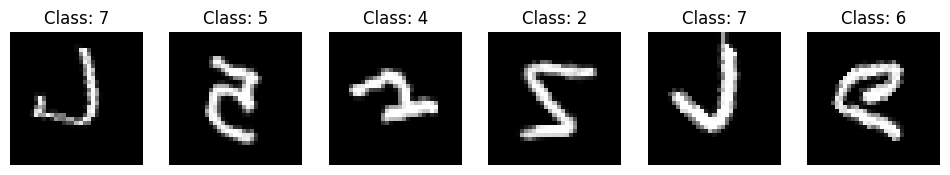

In [ ]:
indices_to_plot = [30, 100, 350, 600, 1000, 1500]
num_images = len(indices_to_plot)
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))

for i, index in enumerate(indices_to_plot):
    image, label = train_set[index], train_labels[index]
    image_to_plot = image.numpy()
    if len(image_to_plot.shape) == 3:
        image_to_plot = image_to_plot.squeeze()

    axes[i].imshow(image_to_plot, cmap="gray")
    axes[i].set_title(f"Class: {label}")
    axes[i].axis('off')
plt.show()


Imbalanced datasets in deep learning cause biased models, poor performance on minority classes, and decreased overall performance. They can lead to overfitting, incorrect confidence estimates, and gradient issues. So let's check the distribution of instances for each class.

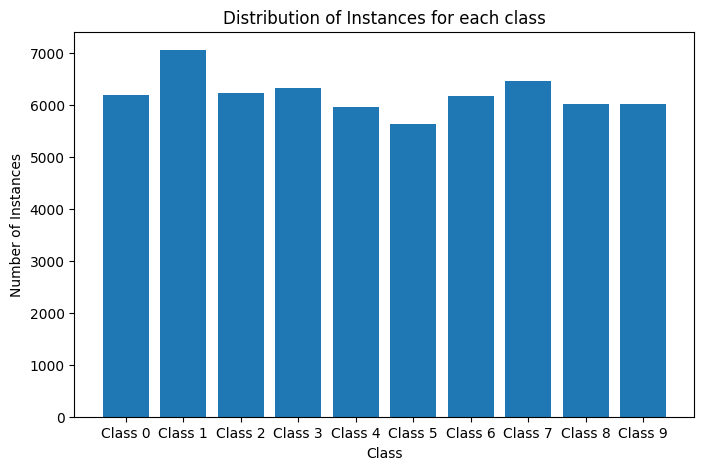

In [ ]:
num_classes = max(train_labels) + 1
class_counts = np.zeros(num_classes)
for label in train_labels:
    class_counts[label] += 1
for label in validation_labels:
    class_counts[label] += 1
for label in test_labels:
    class_counts[label] += 1
class_names = [f"Class {i}" for i in range(num_classes)]

plt.figure(figsize=(8, 5))
plt.bar(class_names, class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.title("Distribution of Instances for each class")
plt.show()

As can be noticed, the dataset is well-balanced, so there is no need to address any class imbalance issues.

This code enables the automatic selection of suitable hardware (GPU if available, otherwise CPU) for PyTorch operations, making it adaptable to various system configurations. Utilizing a GPU for deep learning training significantly improves computational speed and performance compared to using just the CPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


At this stage, we have reached the focal point of this project: comparing the performance of a Group Equivariant Convolutional Network (referred to as P4CNN, as in the paper) with a regular CNN (named Z2CNN) on this dataset.

 First and foremost, we need to create a function that defines the training process.

In [ ]:
def batch_gd(model, criterion, optimizer, train_loader, val_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            train_loss.append(loss.item())

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)
        validation_loss = []

        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            loss = criterion(output, targets)
            validation_loss.append(loss.item())
        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0
        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Validation_loss:{validation_loss:.3f} Duration:{dt}"
        )
    return train_losses, validation_losses

I tried to reproduce the benchmark CNN architecture as described in the paper. The architecture consists of 7 layers of 3 × 3 convolutions (except for the final layer, which has 4 × 4 convolutions),  20 channels in each layer, relu activation functions, batch normalization, dropout, and max-pooling after layer 2.

In [ ]:
class Z2CNN(nn.Module):
    def __init__(self, n_classes=10):
        super(Z2CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv2d(20, 20, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(20, 20, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv2d(20, 20, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv2d(20, 20, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv2d(20, 20, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv2d(20, 20, kernel_size=4, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(20, 100),
            nn.ReLU(),
            nn.Linear(100, n_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        x = F.log_softmax(x, dim=1)
        return x

model_z2cnn = Z2CNN()
model_z2cnn.to(device)

criterion_z2cnn = nn.CrossEntropyLoss()
optimizer_z2cnn = optim.Adam(model_z2cnn.parameters(), lr=0.0001)

In [ ]:
train_losses_z2cnn, validation_losses_z2cnn = batch_gd(
    model_z2cnn, criterion_z2cnn, optimizer_z2cnn, train_loader, validation_loader, 70
)

Epoch : 1/70 Train_loss:2.300 Validation_loss:2.287 Duration:0:00:11.223789
Epoch : 2/70 Train_loss:2.250 Validation_loss:2.188 Duration:0:00:02.338375
Epoch : 3/70 Train_loss:2.096 Validation_loss:2.018 Duration:0:00:02.697356
Epoch : 4/70 Train_loss:1.956 Validation_loss:1.898 Duration:0:00:02.116636
Epoch : 5/70 Train_loss:1.851 Validation_loss:1.802 Duration:0:00:01.018073
Epoch : 6/70 Train_loss:1.744 Validation_loss:1.698 Duration:0:00:00.970895
Epoch : 7/70 Train_loss:1.651 Validation_loss:1.610 Duration:0:00:01.001899
Epoch : 8/70 Train_loss:1.582 Validation_loss:1.533 Duration:0:00:00.981111
Epoch : 9/70 Train_loss:1.510 Validation_loss:1.464 Duration:0:00:01.025310
Epoch : 10/70 Train_loss:1.448 Validation_loss:1.404 Duration:0:00:01.003543
Epoch : 11/70 Train_loss:1.397 Validation_loss:1.342 Duration:0:00:00.979587
Epoch : 12/70 Train_loss:1.340 Validation_loss:1.305 Duration:0:00:00.956726
Epoch : 13/70 Train_loss:1.296 Validation_loss:1.271 Duration:0:00:01.132656
Epoch : 

This plot illustrates the training and validation loss evolution across the epochs. The subsequent cells contain the calculated accuracy for the training, validation, and test sets.

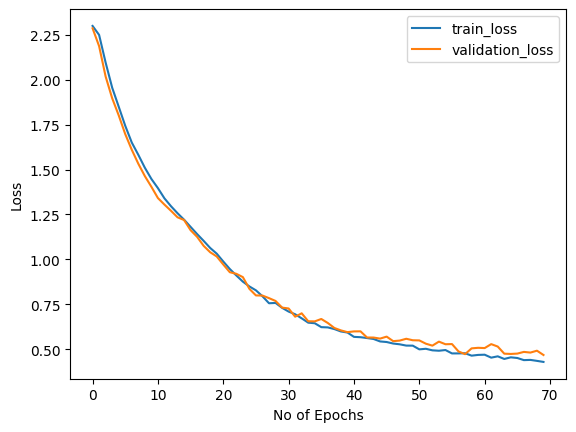

In [ ]:
plt.plot(train_losses_z2cnn , label = 'train_loss')
plt.plot(validation_losses_z2cnn , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def accuracy(loader, model):
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [ ]:
train_acc_z2cnn = accuracy(train_loader, model_z2cnn)
test_acc_z2cnn = accuracy(test_loader, model_z2cnn)
validation_acc_z2cnn = accuracy(validation_loader, model_z2cnn)

In [ ]:
print(
    f"Train Accuracy : {train_acc_z2cnn}\nTest Accuracy : {test_acc_z2cnn}\nValidation Accuracy : {validation_acc_z2cnn}"
)

Train Accuracy : 0.8614
Test Accuracy : 0.8497
Validation Accuracy : 0.854


The model performs quite well on the training data. The test accuracy is slightly lower than the training accuracy but still reasonably high. The validation accuracy is also close to the test accuracy.

If the test accuracy and validation accuracy were significantly lower than the training accuracy, it would indicate overfitting. However, in this scenario, the test and validation accuracies are relatively close to the training accuracy. This suggests that the model is not overfitting but is performing well on unseen data (test data) and the validation data.








Let's save the trained mode for future use.


In [ ]:
torch.save(model_z2cnn.state_dict() , 'model_z2cnn.pt')

In [ ]:
total_params = sum(p.numel() for p in model_z2cnn.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 28070


Checking the number of parameters in the model is crucial because the aim is to conduct a fair comparison between two models (z2cnn and p4cnn) with nearly identical parameter counts.

For the P4CNN, I replaced each convolution by a p4-convolution, divided the number of filters by √4 =
2 (so as to keep the number of parameters approximately
fixed), and added max-pooling after the last
convolution layer.

In [ ]:
class P4CNN(nn.Module):
    def __init__(self, n_classes=10):
        super(P4CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            Lifting_Convolution_C4(1, 10, kernel_size=3, padding=0),
            EquivariantBatchNorm(10),
            nn.ReLU(),
            nn.Dropout(0.3),

            Group_Convolution_p4(10, 10, kernel_size=3, padding=0),
            EquivariantBatchNorm(10),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 0, 0)),

            Group_Convolution_p4(10, 10, kernel_size=3, padding=0),
            EquivariantBatchNorm(10),
            nn.ReLU(),
            nn.Dropout(0.3),

            Group_Convolution_p4(10, 10, kernel_size=3, padding=0),
            EquivariantBatchNorm(10),
            nn.ReLU(),
            nn.Dropout(0.3),

            Group_Convolution_p4(10, 10, kernel_size=3, padding=0),
            EquivariantBatchNorm(10),
            nn.ReLU(),
            nn.Dropout(0.3),

            Group_Convolution_p4(10, 10, kernel_size=3, padding=0),
            EquivariantBatchNorm(10),
            nn.ReLU(),
            nn.Dropout(0.3),

            Group_Convolution_p4(10, 10, kernel_size=4, padding=0),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 0, 0)),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(20 * 2, 100),
            nn.ReLU(),
            nn.Linear(100, n_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        x = F.log_softmax(x, dim=1)
        return x

model_p4cnn = P4CNN()
model_p4cnn.to(device)

criterion_p4cnn = nn.CrossEntropyLoss()
optimizer_p4cnn = optim.Adam(model_p4cnn.parameters(), lr=0.0001)

In [ ]:
total_params = sum(p.numel() for p in model_p4cnn.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 29790


In [ ]:
train_losses_p4cnn, validation_losses_p4cnn = batch_gd(
    model_p4cnn, criterion_p4cnn, optimizer_p4cnn, train_loader, validation_loader, 100
)

Epoch : 1/100 Train_loss:2.324 Validation_loss:2.300 Duration:0:00:02.141778
Epoch : 2/100 Train_loss:2.240 Validation_loss:2.163 Duration:0:00:02.069298
Epoch : 3/100 Train_loss:2.036 Validation_loss:1.913 Duration:0:00:02.052806
Epoch : 4/100 Train_loss:1.829 Validation_loss:1.743 Duration:0:00:02.026246
Epoch : 5/100 Train_loss:1.694 Validation_loss:1.637 Duration:0:00:02.212297
Epoch : 6/100 Train_loss:1.622 Validation_loss:1.571 Duration:0:00:02.534482
Epoch : 7/100 Train_loss:1.543 Validation_loss:1.487 Duration:0:00:02.066326
Epoch : 8/100 Train_loss:1.469 Validation_loss:1.432 Duration:0:00:02.078731
Epoch : 9/100 Train_loss:1.408 Validation_loss:1.366 Duration:0:00:03.034001
Epoch : 10/100 Train_loss:1.340 Validation_loss:1.318 Duration:0:00:02.192795
Epoch : 11/100 Train_loss:1.290 Validation_loss:1.272 Duration:0:00:02.627105
Epoch : 12/100 Train_loss:1.248 Validation_loss:1.238 Duration:0:00:02.034140
Epoch : 13/100 Train_loss:1.198 Validation_loss:1.182 Duration:0:00:02.05

The following cells present the same type of plots and accuracy computations as seen for the previous model.

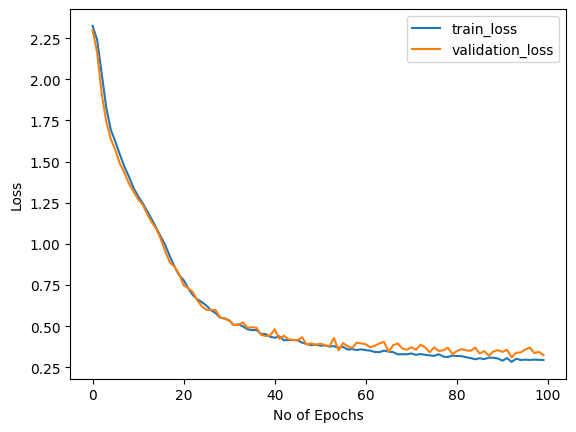

In [ ]:
plt.plot(train_losses_p4cnn, label = 'train_loss')
plt.plot(validation_losses_p4cnn, label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc_p4cnn = accuracy(train_loader, model_p4cnn)
test_acc_p4cnn = accuracy(test_loader, model_p4cnn)
validation_acc_p4cnn = accuracy(validation_loader, model_p4cnn)

In [ ]:
print(
    f"Train Accuracy : {train_acc_p4cnn}\nTest Accuracy : {test_acc_p4cnn}\nValidation Accuracy : {validation_acc_p4cnn}"
)

Train Accuracy : 0.9157
Test Accuracy : 0.9035
Validation Accuracy : 0.9025


In [ ]:
torch.save(model_p4cnn.state_dict() , 'model_p4cnn.pt')

Clearly using a more complex Group Equivariant Convolutional Network, with a significantly higher number of parameters, the results on this dataset can be substantially improved.

In [ ]:
class P4CNN_more_complex(torch.nn.Module):
    def __init__(self, n_classes=10):
        super(P4CNN_more_complex, self).__init__()

        self.conv_layers = nn.Sequential(
            Lifting_Convolution_C4(1, 8, kernel_size=3, padding=1, bias=True),
            Group_Convolution_p4(8, 16, kernel_size=3, padding=1, bias=True),
            EquivariantBatchNorm(16),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Dropout(0.3),

            Group_Convolution_p4(16, 32, kernel_size=3, padding=1, bias=True),
            EquivariantBatchNorm(32),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Dropout(0.3),

            Group_Convolution_p4(32, 64, kernel_size=3, padding=1, bias=True),
            EquivariantBatchNorm(64),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Dropout(0.3),

            Group_Convolution_p4(64, 128, kernel_size=3, padding=1, bias=True),
            EquivariantBatchNorm(128),
            nn.MaxPool3d(kernel_size=(4, 3, 3), stride=(1, 1, 1), padding=(0, 0, 0)),
            nn.ReLU()
        )
        self.linear = nn.Linear(128 * 9, n_classes)

    def forward(self, input):
        out = self.conv_layers(input)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = F.log_softmax(out, dim=1)
        return out


model_p4cnn_mc = P4CNN_more_complex()
model_p4cnn_mc.to(device)

criterion_p4cnn_mc = nn.CrossEntropyLoss()
optimizer_p4cnn_mc = optim.Adam(model_p4cnn_mc.parameters(), lr=0.0001)

In [ ]:
total_params = sum(p.numel() for p in model_p4cnn_mc.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 404010


In [ ]:
train_losses_p4cnn_mc, validation_losses_p4cnn_mc = batch_gd(
    model_p4cnn_mc, criterion_p4cnn_mc, optimizer_p4cnn_mc, train_loader, validation_loader, 30
)

Epoch : 1/30 Train_loss:2.065 Validation_loss:1.877 Duration:0:00:02.918221
Epoch : 2/30 Train_loss:1.745 Validation_loss:1.617 Duration:0:00:02.801214
Epoch : 3/30 Train_loss:1.509 Validation_loss:1.390 Duration:0:00:02.807133
Epoch : 4/30 Train_loss:1.255 Validation_loss:1.105 Duration:0:00:02.804690
Epoch : 5/30 Train_loss:0.935 Validation_loss:0.781 Duration:0:00:02.880415
Epoch : 6/30 Train_loss:0.662 Validation_loss:0.562 Duration:0:00:02.803095
Epoch : 7/30 Train_loss:0.501 Validation_loss:0.476 Duration:0:00:02.806538
Epoch : 8/30 Train_loss:0.403 Validation_loss:0.416 Duration:0:00:02.798611
Epoch : 9/30 Train_loss:0.341 Validation_loss:0.331 Duration:0:00:02.846243
Epoch : 10/30 Train_loss:0.297 Validation_loss:0.349 Duration:0:00:02.834302
Epoch : 11/30 Train_loss:0.265 Validation_loss:0.303 Duration:0:00:02.808484
Epoch : 12/30 Train_loss:0.247 Validation_loss:0.265 Duration:0:00:02.792909
Epoch : 13/30 Train_loss:0.221 Validation_loss:0.278 Duration:0:00:02.828093
Epoch : 

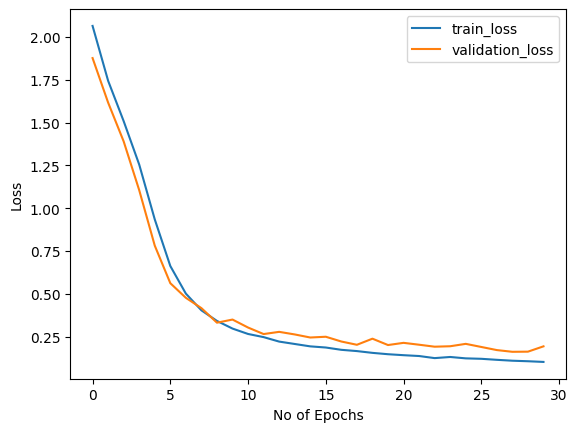

In [ ]:
plt.plot(train_losses_p4cnn_mc, label = 'train_loss')
plt.plot(validation_losses_p4cnn_mc, label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc_p4cnn_mc = accuracy(train_loader, model_p4cnn_mc)
test_acc_p4cnn_mc = accuracy(test_loader, model_p4cnn_mc)
validation_acc_p4cnn_mc = accuracy(validation_loader, model_p4cnn_mc)

In [ ]:
print(
    f"Train Accuracy : {train_acc_p4cnn_mc}\nTest Accuracy : {test_acc_p4cnn_mc}\nValidation Accuracy : {validation_acc_p4cnn_mc}"
)

Train Accuracy : 0.9642
Test Accuracy : 0.95124
Validation Accuracy : 0.939


In [ ]:
torch.save(model_p4cnn_mc.state_dict() , 'model_p4cnn_mc.pt')

Let's compare the performances of Z2CNN, P4CNN and P4CNN_mc (please note that these values may vary slightly between different training runs):

<table>
  <tr>
    <th>Network</th>
    <th>Train accuracy</th>
    <th>Validation accuracy</th>
    <th>Test accuracy</th>
    <th>Parameters</th>
  </tr>
  <tr>
    <td>Z2CNN</td>
    <td>0.8662</td>
    <td>0.8485</td>
    <td>0.85476</td>
    <td>28070</td>
  </tr>
  <tr>
    <td>P4CNN</td>
    <td>0.9157</td>
    <td> 0.9025</td>
    <td> 0.9035</td>
    <td>29790</td>
  </tr>
  <tr>
    <td>P4CNN_mc</td>
    <td>0.9642</td>
    <td>0.939</td>
    <td>0.95124</td>
    <td>404010</td>
  </tr>
</table>



P4CNN outperforms Z2CNN across all three metrics: train accuracy, validation accuracy, and test accuracy. The design of Group Equivariant CNNs allows them to effectively capture and leverage symmetries in the rotated MNIST dataset, giving them an advantage over simple CNNs, which lack explicit mechanisms for handling such symmetries and are more orientation-sensitive.

Moreover, using a more complex Group Equivariant CNN like P4CNN_mc further improves performance.



---



Working on this project, I became intrigued by the potential applications of Group Equivariant Convolutional Networks and whether they could offer increased robustness against adversarial attacks compared to traditional CNNs. Deep neural networks have been shown to be vulnerable to adversarial examples:
very small perturbations of the input can have a dramatic impact on the predictions.

The idea behind G-CNNs, which leverage symmetries and invariances in input data, suggests that they might generalize better and exhibit more resilience to certain perturbations, such as those introduced by adversarial attacks. However, despite searching through existing literature, I couldn't find a definitive answer to my question. To satisfy this curiosity, I decided to conduct experiments myself.

An adversarial attack consists of subtly modifying an original image in such a way that the changes are almost undetectable to the human eye. The modified image is called an adversarial image, and when submitted to a classifier is misclassified, while the original one is correctly classified. The real-life applications of such attacks can be very serious –for instance, one could modify a traffic sign to be misinterpreted by an autonomous vehicle, and cause an accident. Another example is the potential risk of inappropriate or illegal content being modified so that it's undetectable by the content moderation algorithms used in popular websites or by police web crawlers.

Most successful attacks are gradient-based methods. Namely the attackers modify the image in the direction of the gradient of the loss function with respect to the input image.

The technique I will use to generate adversarial examples is Fast Gradient Sign Method (FGSM).

FGSM was introduced by Ian Goodfellow and his colleagues in the paper ["Explaining and harnessing adversarial examples"](https://arxiv.org/abs/1412.6572) as a way to efficiently generate these adversarial examples. The method is specifically designed for models that are based on neural networks, but it can be adapted to other machine learning models as well. FGSM is a type of white-box attack, meaning it assumes the attacker has full access to the architecture and parameters of the target model.

Given a linear classifier with weight matrix $w$ and input $x$, an adversarial example $\tilde{x}$ can be generated by adding a perturbation $\eta$, such that $\tilde{x} = x + \eta$.

The logits of the classifier for the adversarial example are given by $w^\top \tilde{x} = w^\top (x + \eta) = w^\top x + w^\top \eta$.
This means that, given a small perturbation η
, the actual effect of the perturbation on the logits of the classifier is given by is $w^\top \eta$.

The idea behind FGSM is surprisingly simple: we do opposite of the typical gradient descent in order to maximize the loss, since confusing the model is the end goal of adversarial attack. To find the adversarial example, the perturbation $\eta$ is set to $\eta = \epsilon \cdot \text{sign}(\nabla_x J(w,x,y))$, where $J$ is the cost function, $\nabla_x J(w,x,y)$ is the gradient of the cost function with respect to the input $x$, and $y$ is the ground truth label.

The goal of an adversarial attack is to maximize the second term in the first-order approximation of the cost function.
The perturbed example that maximizes the loss function while satisfying the constraint $\| \tilde{x} - x \|_\infty \leq \epsilon$ is given by $\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_x J(w,x,y))$.



Let's see the implementation. The models I will compare are Z2CNN and P4CNN.

In [ ]:
model_z2cnn = Z2CNN().to(device)
model_z2cnn.load_state_dict(torch.load("model_z2cnn.pt", map_location=device))
model_z2cnn.eval()

Z2CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (17): BatchNorm2d(20, eps=1e-05, momen

In [ ]:
model_p4cnn = P4CNN().to(device)
model_p4cnn.load_state_dict(torch.load("model_p4cnn.pt", map_location=device))
model_p4cnn.eval()

P4CNN(
  (conv_layers): Sequential(
    (0): Lifting_Convolution_C4()
    (1): EquivariantBatchNorm(
      (batch_norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Group_Convolution_p4()
    (5): EquivariantBatchNorm(
      (batch_norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (6): ReLU()
    (7): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 0, 0), dilation=1, ceil_mode=False)
    (8): Group_Convolution_p4()
    (9): EquivariantBatchNorm(
      (batch_norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Group_Convolution_p4()
    (13): EquivariantBatchNorm(
      (batch_norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (14): ReLU()
    (15): Dropout(p=0.3, inplac

Since we want to create perturbations for each image, we need to set the batch size to be one.

In [ ]:
test_loader_aa = DataLoader(TensorDataset(test_set, test_labels), batch_size=1)

Now, we'll proceed with the implementation of FGSM. In the following function, we take an image as input along with a small value epsilon. By utilizing the gradient's sign, we generate a slight perturbation, which we subsequently add to the image. To ensure the perturbed image maintains valid normalized pixel values (ranging from 0 to 1), we use clamping.

In [ ]:
def fgsm_attack(image, epsilon):
    perturbed_image = image + epsilon * image.grad.data.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

Let's create a custom loop function to evaluate each image in the test loader and generate predictions. It aims to create adversarial examples by perturbing images that were originally classified correctly by the model. The key implementation detail involves setting the requires_grad property to true, enabling gradient calculation for the input. The function then backpropagates the loss to obtain gradient values and uses the fgsm_attack function to generate perturbed images. Successful adversarial examples are stored in a list for demonstration, and the function also calculates and returns the model's accuracy.

In [ ]:
def test(model, model_name, test_loader, epsilon, device, num_display=5):
    num_correct = 0
    adv_examples = []

    for image, label in test_loader:
        image = image.to(device)
        label = label.to(device)
        image.requires_grad = True

        output = model(image)
        _, init_pred = output.max(dim=1)

        if init_pred.item() != label.item():
            continue

        loss = F.nll_loss(output, label)
        model.zero_grad()
        loss.backward()

        perturbed_image = fgsm_attack(image, epsilon)
        perturbed_output = model(perturbed_image)
        _, perturbed_pred = perturbed_output.max(dim=1)

        if perturbed_pred.item() == label.item():
            num_correct += 1
        elif len(adv_examples) < num_display:
            adv_examples.append((label.item(), perturbed_pred.item(), perturbed_image.squeeze()))

    accuracy = num_correct / len(test_loader)
    print(f"Epsilon: {epsilon}, Model: {model_name}, Accuracy: {accuracy:.3f}")

    return accuracy, adv_examples

Let’s define some epsilon values and run the test. Intuitively, we would expect the accuracy of the model to go down as the epsilon value increases; a higher epsilon value corresponds to a larger perturbation, which could more adversely impact the model.

In [ ]:
num_display = 5
accuracies_z2cnn = []
accuracies_p4cnn = []
all_adv_examples_z2cnn = []
all_adv_examples_p4cnn = []
model_name1 = "z2cnn"
model_name2 = "p4cnn"
epsilons = [.05, .1, .15, .2]

for epsilon in epsilons:
    accuracy_z2cnn, adv_examples_z2cnn = test(model_z2cnn, model_name1, test_loader_aa, epsilon, device, num_display)
    accuracies_z2cnn.append(accuracy_z2cnn)
    all_adv_examples_z2cnn.append(adv_examples_z2cnn)

    accuracy_p4cnn, adv_examples_p4cnn = test(model_p4cnn, model_name2, test_loader_aa, epsilon, device, num_display)
    accuracies_p4cnn.append(accuracy_p4cnn)
    all_adv_examples_p4cnn.append(adv_examples_p4cnn)

Epsilon: 0.05, Model: z2cnn, Accuracy: 0.699
Epsilon: 0.05, Model: p4cnn, Accuracy: 0.767
Epsilon: 0.1, Model: z2cnn, Accuracy: 0.426
Epsilon: 0.1, Model: p4cnn, Accuracy: 0.480
Epsilon: 0.15, Model: z2cnn, Accuracy: 0.223
Epsilon: 0.15, Model: p4cnn, Accuracy: 0.258
Epsilon: 0.2, Model: z2cnn, Accuracy: 0.149
Epsilon: 0.2, Model: p4cnn, Accuracy: 0.156


<ipython-input-61-f5effa179d49>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


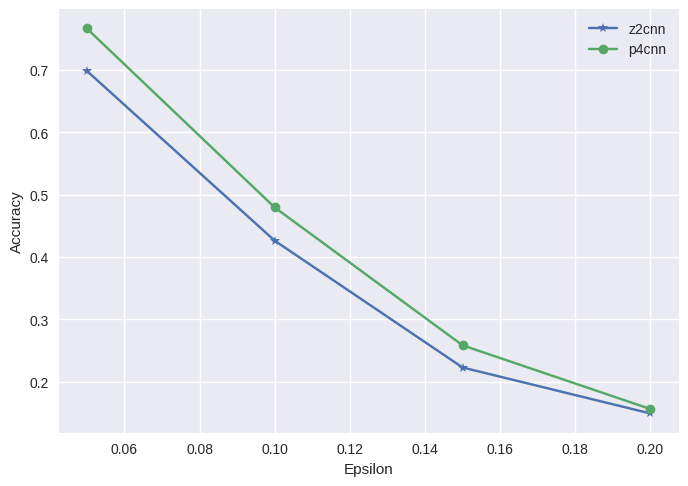

In [ ]:
plt.style.use("seaborn")
plt.plot(epsilons, accuracies_z2cnn, "*-", label="z2cnn")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.plot(epsilons, accuracies_p4cnn, "o-", label="p4cnn")
plt.legend()
plt.show()

We can observe that the P4CNN outperforms the Z2CNN on this kind of adversarial attacks. This is probably due to its ability to capture geometric structure, making it more robust in recognizing objects under various transformations includig perturbations.

Let’s take a look at the adversarial examples that have been generated for each value of epsilon with the model P4CNN.

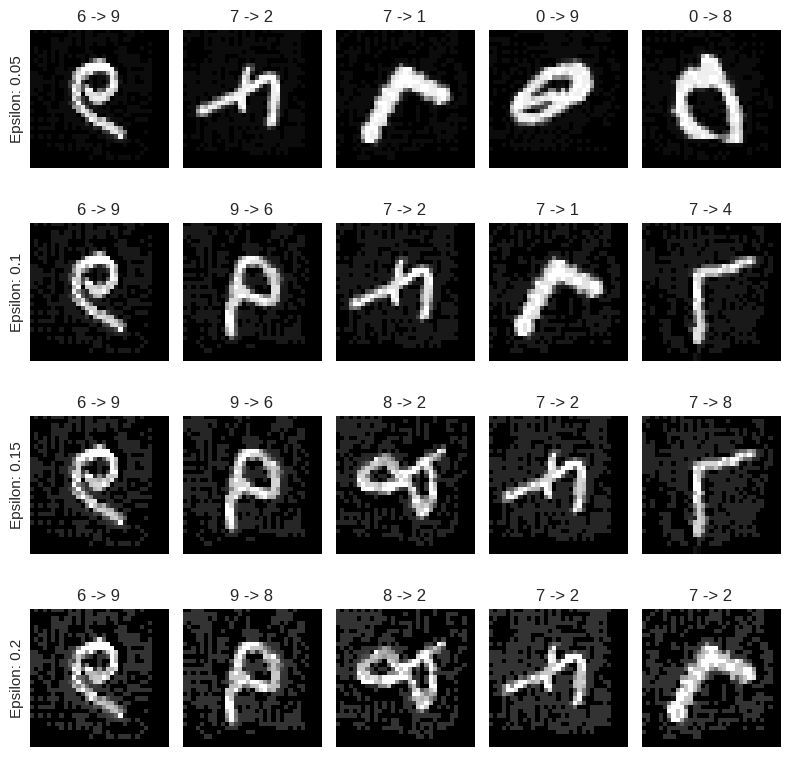

In [ ]:
def clean_axis(axis):
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xticklabels([])
    axis.set_yticklabels([])

nrows = len(epsilons)
ncols = num_display

fig, ax = plt.subplots(4, 5, figsize=(8, 8))

for row in range(nrows):
    for col in range(ncols):
        label, perturbed_pred, perturbed_image = all_adv_examples_p4cnn[row][col]
        axis = ax[row, col]
        perturbed_image_cpu = perturbed_image.cpu()
        perturbed_image_np = perturbed_image_cpu.detach().numpy()

        axis.imshow(perturbed_image_np, cmap="gray")
        axis.set_title(f"{label} -> {perturbed_pred}")
        clean_axis(axis)
        if col == 0:
            axis.set_ylabel(f"Epsilon: {epsilons[row]}")
plt.tight_layout()
plt.show()

# **4. Experiments on CIFAR-10**

The CIFAR-10 dataset consists of 60k images of size 32× 32, divided into 10 classes. The dataset is split into 40k
training, 10k validation and 10k testing splits. The images are in RGB format.

The CIFAR-10 dataset consists of the following ten classes:

*   Plane
*   Car
*   Deer
*   Bird
*   Cat
*   Dog
*   Frog
*   Horse
*   Ship
*   Truck

In [ ]:
train_transform = transforms.Compose(
    [transforms.ToTensor(),
      transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])])


train_data_cifar = datasets.CIFAR10("/content/dataset", train=True, download=True, transform=train_transform)

test_data_cifar = datasets.CIFAR10("/content/dataset", train=False, download=True, transform=test_transform)

output_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_size = 40000
val_size = len(train_data_cifar) - train_size

train_dataset_cifar, val_dataset_cifar = random_split(train_data_cifar, [train_size, val_size])
batch_size = 128

train_loader_cifar = torch.utils.data.DataLoader(train_dataset_cifar, batch_size=batch_size, shuffle=True)
val_loader_cifar = torch.utils.data.DataLoader(val_dataset_cifar, batch_size=batch_size, shuffle=False)
test_loader_cifar = torch.utils.data.DataLoader(test_data_cifar, batch_size=batch_size, shuffle=False)

print("Number of samples in the training set:", len(train_dataset_cifar))
print("Number of samples in the validation set:", len(val_dataset_cifar))
print("Number of samples in the test set:", len(test_data_cifar))


Number of samples in the training set: 40000
Number of samples in the validation set: 10000
Number of samples in the test set: 10000


In [ ]:
train_labels_cifar = train_dataset_cifar.dataset.targets
val_labels_cifar = val_dataset_cifar.dataset.targets
test_labels_cifar = test_data_cifar.targets

num_classes_cifar = len(set(train_labels_cifar))

print("Number of classes is:", num_classes_cifar)

Number of classes is: 10


In [ ]:
image_index = 0
image, label = train_data_cifar[image_index]
print("Image shape:", image.shape)

Image shape: torch.Size([3, 32, 32])


Let's visualize images from the dataset with their relative labels:

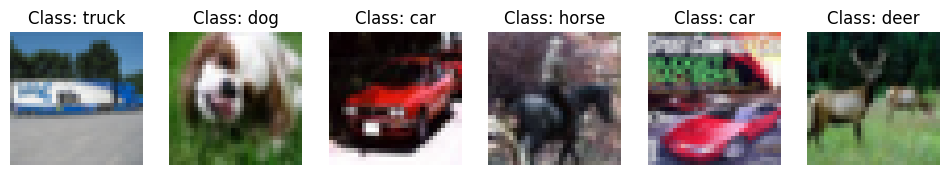

In [ ]:
indices_to_plot = [30, 100, 350, 600, 1000, 1500]
num_images = len(indices_to_plot)
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))

for i, index in enumerate(indices_to_plot):
    image, label = train_dataset_cifar[index]
    image_to_plot = image.numpy().transpose(1, 2, 0)
    image_to_plot = (image_to_plot * [0.2023, 0.1994, 0.2010]) + [0.4914, 0.4822, 0.4465]
    image_to_plot = image_to_plot.clip(0, 1)

    axes[i].imshow(image_to_plot)
    axes[i].set_title(f"Class: {output_classes[label]}")
    axes[i].axis('off')

plt.show()

Let's check the distribution of instances for each class.

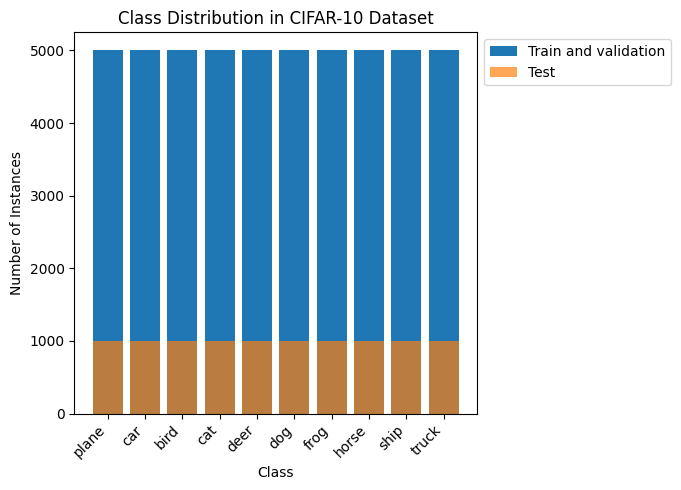

In [ ]:
train_class_counts = torch.zeros(len(output_classes), dtype=torch.int)
for _, label in train_data_cifar:
    train_class_counts[label] += 1

test_class_counts = torch.zeros(len(output_classes), dtype=torch.int)
for _, label in test_data_cifar:
    test_class_counts[label] += 1

plt.figure(figsize=(8, 5))
plt.bar(output_classes, train_class_counts, label='Train and validation')
plt.bar(output_classes, test_class_counts, label='Test', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in CIFAR-10 Dataset')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right', bbox_to_anchor=(1.50, 1))
plt.tight_layout()
plt.show()

As can be noticed, the dataset is perfectly balanced, so there is no need to address any class imbalance issues.

All the networks I will try on this dataset are reproductions of the architectures described in the "Group Equivariant Convolutional Networks" paper.

I compared the p4-, p4m- and standard planar Z <sup>2</sup>
convolutions on two kinds of baseline architectures.

The first baseline is the All-CNN-C architecture by
[Springenberg et al. (2015)](https://arxiv.org/abs/1412.6806), which consists of a sequence of 9 strided and non-strided convolution layers, interspersed
with rectified linear activation units, rectified linear activation units, batch normalization layers and some dropouts.

In [ ]:
class AllCNNC(nn.Module):
    def __init__(self, num_classes=10):
        super(AllCNNC, self).__init__()
        self.features = nn.Sequential(
            nn.Dropout(0.2),
            nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),

            nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(96),

            nn.Conv2d(96, 96, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.Dropout(0.7),

            nn.Conv2d(96, 192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(),

            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(),

            nn.Conv2d(192, 192, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.Dropout(0.7),

            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(),

            nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(192),
            nn.ReLU(),

            nn.Conv2d(192, num_classes, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(10),
            nn.ReLU(),
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

model_allcnnc = AllCNNC()
model_allcnnc.to(device)

weight_decay = 1e-4

criterion_allcnnc = nn.CrossEntropyLoss()
optimizer_allcnnc = optim.Adam(model_allcnnc.parameters(), lr=0.001, weight_decay=weight_decay)

In [ ]:
total_params = sum(p.numel() for p in model_allcnnc.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 1372254


In [ ]:
train_losses_allcnnc, validation_losses_allcnnc = batch_gd(
    model_allcnnc, criterion_allcnnc, optimizer_allcnnc, train_loader_cifar, val_loader_cifar, 15
)

Epoch : 1/15 Train_loss:1.709 Validation_loss:1.490 Duration:0:00:30.517933
Epoch : 2/15 Train_loss:1.377 Validation_loss:1.277 Duration:0:00:21.752645
Epoch : 3/15 Train_loss:1.204 Validation_loss:1.169 Duration:0:00:22.627167
Epoch : 4/15 Train_loss:1.097 Validation_loss:1.066 Duration:0:00:23.030699
Epoch : 5/15 Train_loss:1.014 Validation_loss:0.992 Duration:0:00:22.177864
Epoch : 6/15 Train_loss:0.945 Validation_loss:0.926 Duration:0:00:22.168997
Epoch : 7/15 Train_loss:0.885 Validation_loss:0.866 Duration:0:00:22.289471
Epoch : 8/15 Train_loss:0.834 Validation_loss:0.843 Duration:0:00:21.725169
Epoch : 9/15 Train_loss:0.792 Validation_loss:0.816 Duration:0:00:22.229270
Epoch : 10/15 Train_loss:0.763 Validation_loss:0.780 Duration:0:00:22.462276
Epoch : 11/15 Train_loss:0.732 Validation_loss:0.770 Duration:0:00:22.681299
Epoch : 12/15 Train_loss:0.709 Validation_loss:0.758 Duration:0:00:22.515152
Epoch : 13/15 Train_loss:0.684 Validation_loss:0.741 Duration:0:00:22.282159
Epoch : 

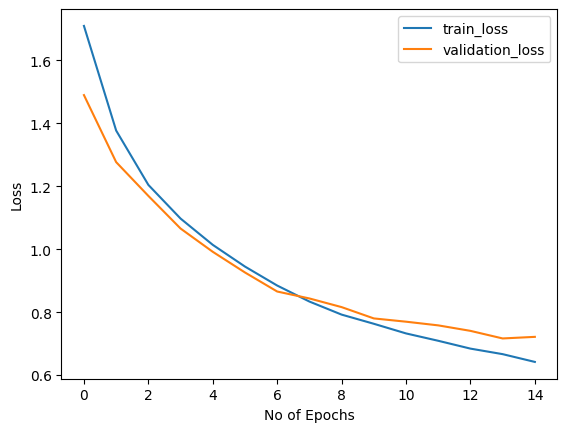

In [ ]:
plt.plot(train_losses_allcnnc, label = 'train_loss')
plt.plot(validation_losses_allcnnc, label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc_allcnnc = accuracy(train_loader_cifar, model_allcnnc)
test_acc_allcnnc = accuracy(test_loader_cifar, model_allcnnc)
validation_acc_allcnnc = accuracy(val_loader_cifar, model_allcnnc)

In [ ]:
print(
    f"Train Accuracy : {train_acc_allcnnc}\nTest Accuracy : {test_acc_allcnnc}\nValidation Accuracy : {validation_acc_allcnnc}"
)

Train Accuracy : 0.79225
Test Accuracy : 0.7507
Validation Accuracy : 0.7578


In [ ]:
torch.save(model_allcnnc.state_dict() , 'model_allcnnc.pt')

To evaluate G-CNNs, I replaced all convolution layers of the baseline architectures by p4 or p4m convolutions. For a
constant number of filters, this increases the size of the feature maps
4 or 8-fold, which in turn increases the number of
parameters required per filter in the next layer. Hence, I
halve the number of filters in each p4-conv layer, and divide
it by roughly √8 ≈ 3 in each p4m-conv layer. This way,
the number of parameters is left approximately invariant,
while the size of the internal representation is increased.

In [ ]:
class P4AllCNNC(nn.Module):
    def __init__(self, num_classes=10):
        super(P4AllCNNC, self).__init__()
        self.features = nn.Sequential(
            nn.Dropout(0.2),
            Lifting_Convolution_C4(3, 48, kernel_size=3, stride=1, padding=1),
            EquivariantBatchNorm(48),
            nn.ReLU(),

            Group_Convolution_p4(48, 48, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            EquivariantBatchNorm(48),

            Group_Convolution_p4(48, 48, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            EquivariantBatchNorm(48),
            nn.Dropout(0.7),

            Group_Convolution_p4(48, 96, kernel_size=3, stride=1, padding=1),
            EquivariantBatchNorm(96),
            nn.ReLU(),

            Group_Convolution_p4(96, 96, kernel_size=3, stride=1, padding=1),
            EquivariantBatchNorm(96),
            nn.ReLU(),

            Group_Convolution_p4(96, 96, kernel_size=3, stride=2, padding=1),
            EquivariantBatchNorm(96),
            nn.ReLU(),
            nn.Dropout(0.7),

            Group_Convolution_p4(96, 96, kernel_size=3, stride=1, padding=1),
            EquivariantBatchNorm(96),
            nn.ReLU(),

            Group_Convolution_p4(96, 96, kernel_size=1, stride=1, padding=0),
            EquivariantBatchNorm(96),
            nn.ReLU(),

            Group_Convolution_p4(96, num_classes, kernel_size=1, stride=1, padding=0),
            EquivariantBatchNorm(10),
            nn.ReLU(),
        )
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

model_p4allcnnc = P4AllCNNC()
model_p4allcnnc.to(device)

weight_decay = 1e-4

criterion_p4allcnnc = nn.CrossEntropyLoss()
optimizer_p4allcnnc = optim.Adam(model_p4allcnnc.parameters(), lr=0.001, weight_decay=weight_decay)

In [ ]:
total_params = sum(p.numel() for p in model_p4allcnnc.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 1371006


In [ ]:
train_losses_p4allcnnc, validation_losses_p4allcnnc = batch_gd(
    model_p4allcnnc, criterion_p4allcnnc, optimizer_p4allcnnc, train_loader_cifar, val_loader_cifar, 20
)

Epoch : 1/20 Train_loss:1.880 Validation_loss:1.700 Duration:0:01:00.199669
Epoch : 2/20 Train_loss:1.627 Validation_loss:1.531 Duration:0:00:56.481236
Epoch : 3/20 Train_loss:1.470 Validation_loss:1.404 Duration:0:00:56.793278
Epoch : 4/20 Train_loss:1.357 Validation_loss:1.322 Duration:0:00:56.799685
Epoch : 5/20 Train_loss:1.283 Validation_loss:1.233 Duration:0:00:58.609175
Epoch : 6/20 Train_loss:1.214 Validation_loss:1.205 Duration:0:00:58.273619
Epoch : 7/20 Train_loss:1.155 Validation_loss:1.136 Duration:0:00:57.321201
Epoch : 8/20 Train_loss:1.097 Validation_loss:1.080 Duration:0:00:58.027104
Epoch : 9/20 Train_loss:1.035 Validation_loss:1.046 Duration:0:00:56.961618
Epoch : 10/20 Train_loss:0.980 Validation_loss:0.971 Duration:0:00:57.487379
Epoch : 11/20 Train_loss:0.925 Validation_loss:0.918 Duration:0:00:57.593977
Epoch : 12/20 Train_loss:0.874 Validation_loss:0.885 Duration:0:00:56.587774
Epoch : 13/20 Train_loss:0.832 Validation_loss:0.845 Duration:0:00:56.869357
Epoch : 

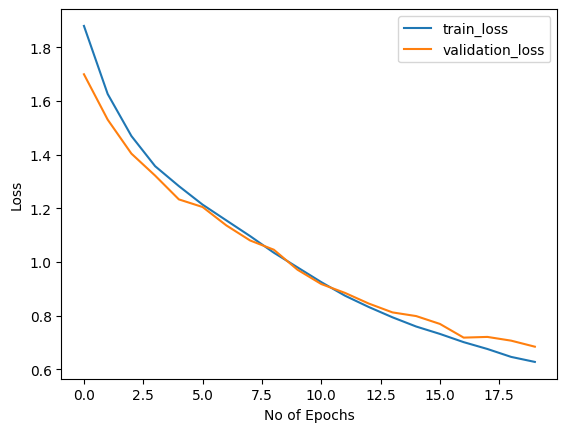

In [ ]:
plt.plot(train_losses_p4allcnnc, label = 'train_loss')
plt.plot(validation_losses_p4allcnnc, label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc_p4allcnnc = accuracy(train_loader_cifar, model_p4allcnnc)
test_acc_p4allcnnc = accuracy(test_loader_cifar, model_p4allcnnc)
validation_acc_p4allcnnc = accuracy(val_loader_cifar, model_p4allcnnc)

In [ ]:
print(
    f"Train Accuracy : {train_acc_p4allcnnc}\nTest Accuracy : {test_acc_p4allcnnc}\nValidation Accuracy : {validation_acc_p4allcnnc}"
)

Train Accuracy : 0.800075
Test Accuracy : 0.7595
Validation Accuracy : 0.7631


In [ ]:
torch.save(model_p4allcnnc.state_dict() , 'model_p4allcnnc.pt')

In [ ]:
class P4MAllCNNC(nn.Module):
    def __init__(self, num_classes=10):
        super(P4MAllCNNC, self).__init__()
        self.features = nn.Sequential(
            nn.Dropout(0.2),
            Lifting_Convolution_D4(3, 32, kernel_size=3, stride=1, padding=1),
            EquivariantBatchNorm(32),
            nn.ReLU(),

            Group_Convolution_p4m(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            EquivariantBatchNorm(32),

            Group_Convolution_p4m(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            EquivariantBatchNorm(32),
            nn.Dropout(0.7),

            Group_Convolution_p4m(32, 64, kernel_size=3, stride=1, padding=1),
            EquivariantBatchNorm(64),
            nn.ReLU(),

            Group_Convolution_p4m(64, 64, kernel_size=3, stride=1, padding=1),
            EquivariantBatchNorm(64),
            nn.ReLU(),

            Group_Convolution_p4m(64, 64, kernel_size=3, stride=2, padding=1),
            EquivariantBatchNorm(64),
            nn.ReLU(),
            nn.Dropout(0.7),

            Group_Convolution_p4m(64, 64, kernel_size=3, stride=1, padding=1),
            EquivariantBatchNorm(64),
            nn.ReLU(),

            Group_Convolution_p4m(64, 64, kernel_size=1, stride=1, padding=0),
            EquivariantBatchNorm(64),
            nn.ReLU(),

            Group_Convolution_p4m(64, num_classes, kernel_size=1, stride=1, padding=0),
            EquivariantBatchNorm(10),
            nn.ReLU(),
        )
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

model_p4mallcnnc = P4MAllCNNC()
model_p4mallcnnc.to(device)

weight_decay = 1e-4

criterion_p4mallcnnc = nn.CrossEntropyLoss()
optimizer_p4mallcnnc = optim.Adam(model_p4mallcnnc.parameters(), lr=0.001, weight_decay=weight_decay)

In [ ]:
total_params = sum(p.numel() for p in model_p4mallcnnc.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 1219678


In [ ]:
train_losses_p4mallcnnc, validation_losses_p4mallcnnc = batch_gd(
    model_p4mallcnnc, criterion_p4mallcnnc, optimizer_p4mallcnnc, train_loader_cifar, val_loader_cifar, 20
)

Epoch : 1/20 Train_loss:1.867 Validation_loss:1.698 Duration:0:03:05.500028
Epoch : 2/20 Train_loss:1.603 Validation_loss:1.494 Duration:0:03:02.028507
Epoch : 3/20 Train_loss:1.445 Validation_loss:1.373 Duration:0:02:48.279116
Epoch : 4/20 Train_loss:1.326 Validation_loss:1.289 Duration:0:02:48.675762
Epoch : 5/20 Train_loss:1.230 Validation_loss:1.180 Duration:0:02:48.412714
Epoch : 6/20 Train_loss:1.145 Validation_loss:1.099 Duration:0:02:48.645661
Epoch : 7/20 Train_loss:1.072 Validation_loss:1.063 Duration:0:02:49.332438
Epoch : 8/20 Train_loss:1.005 Validation_loss:0.983 Duration:0:02:47.790444
Epoch : 9/20 Train_loss:0.943 Validation_loss:0.925 Duration:0:02:48.005556
Epoch : 10/20 Train_loss:0.897 Validation_loss:0.895 Duration:0:02:47.902672
Epoch : 11/20 Train_loss:0.854 Validation_loss:0.865 Duration:0:02:47.496082
Epoch : 12/20 Train_loss:0.815 Validation_loss:0.858 Duration:0:02:47.760242
Epoch : 13/20 Train_loss:0.785 Validation_loss:0.825 Duration:0:02:47.144263
Epoch : 

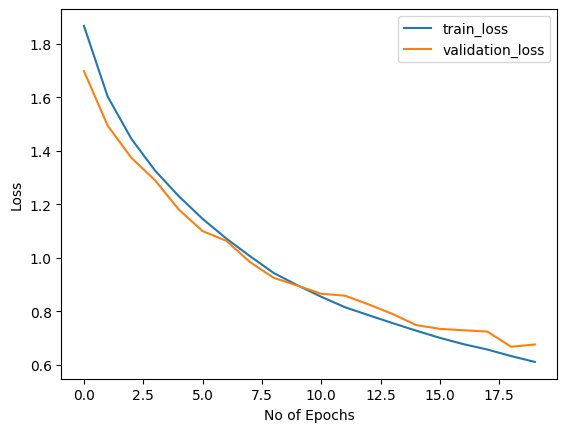

In [ ]:
plt.plot(train_losses_p4mallcnnc, label = 'train_loss')
plt.plot(validation_losses_p4mallcnnc, label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc_p4mallcnnc = accuracy(train_loader_cifar, model_p4mallcnnc)
test_acc_p4mallcnnc = accuracy(test_loader_cifar, model_p4mallcnnc)
validation_acc_p4mallcnnc = accuracy(val_loader_cifar, model_p4mallcnnc)

In [ ]:
print(
    f"Train Accuracy : {train_acc_p4mallcnnc}\nTest Accuracy : {test_acc_p4mallcnnc}\nValidation Accuracy : {validation_acc_p4mallcnnc}"
)

Train Accuracy : 0.805375
Test Accuracy : 0.7696
Validation Accuracy : 0.7748


In [ ]:
torch.save(model_p4mallcnnc.state_dict() , 'model_p4mallcnnc.pt')

So far, the best model is P4MAllCNNC, but the performances of the three networks are pretty much similar.

To evaluate the impact of data augmentation, I will compare
the networks on CIFAR10 and augmented CIFAR10+.

Data augmentation is a technique used to expand the training dataset by creating modified versions of original samples while preserving their labels and characteristics. It helps improve model robustness and generalization by exposing it to various data variations.


CIFAR10+ differs from vanilla CIFAR10 for moderate data augmentation with horizontal flips and small translations.

In [ ]:
train_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

train_data_cifar_plus = datasets.CIFAR10("/content/dataset", train=True, download=True, transform=train_augmentation)
test_data_cifar_plus = datasets.CIFAR10("/content/dataset", train=False, download=True, transform=test_transform)

train_dataset_cifar_plus, val_dataset_cifar_plus = random_split(train_data_cifar_plus, [train_size, val_size])

train_loader_cifar_plus = torch.utils.data.DataLoader(train_dataset_cifar_plus, batch_size=128, shuffle=True)
val_loader_cifar_plus = torch.utils.data.DataLoader(val_dataset_cifar_plus, batch_size=128, shuffle=False)
test_loader_cifar_plus = torch.utils.data.DataLoader(test_data_cifar_plus, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Now it is time to train and test all the networks seen in this section (AllCNNC, P4AllCNNC, P4MAllCNNC) on CIFAR10+.

In [ ]:
model_allcnnc_plus = AllCNNC()
model_allcnnc_plus.to(device)

weight_decay = 1e-4

criterion_allcnnc_plus = nn.CrossEntropyLoss()
optimizer_allcnnc_plus = optim.Adam(model_allcnnc_plus.parameters(), lr=0.001, weight_decay=weight_decay)

train_losses_allcnnc_plus, validation_losses_allcnnc_plus = batch_gd(
    model_allcnnc_plus, criterion_allcnnc_plus, optimizer_allcnnc_plus, train_loader_cifar_plus, val_loader_cifar_plus, 25
)

Epoch : 1/25 Train_loss:1.767 Validation_loss:1.559 Duration:0:00:37.448573
Epoch : 2/25 Train_loss:1.448 Validation_loss:1.386 Duration:0:00:30.129725
Epoch : 3/25 Train_loss:1.279 Validation_loss:1.252 Duration:0:00:30.657577
Epoch : 4/25 Train_loss:1.175 Validation_loss:1.185 Duration:0:00:30.219065
Epoch : 5/25 Train_loss:1.106 Validation_loss:1.080 Duration:0:00:29.606761
Epoch : 6/25 Train_loss:1.050 Validation_loss:1.066 Duration:0:00:30.382723
Epoch : 7/25 Train_loss:0.998 Validation_loss:0.998 Duration:0:00:30.159835
Epoch : 8/25 Train_loss:0.954 Validation_loss:0.960 Duration:0:00:30.450458
Epoch : 9/25 Train_loss:0.912 Validation_loss:0.933 Duration:0:00:30.539682
Epoch : 10/25 Train_loss:0.876 Validation_loss:0.903 Duration:0:00:29.838060
Epoch : 11/25 Train_loss:0.846 Validation_loss:0.882 Duration:0:00:30.750106
Epoch : 12/25 Train_loss:0.816 Validation_loss:0.860 Duration:0:00:30.076939
Epoch : 13/25 Train_loss:0.799 Validation_loss:0.849 Duration:0:00:30.704312
Epoch : 

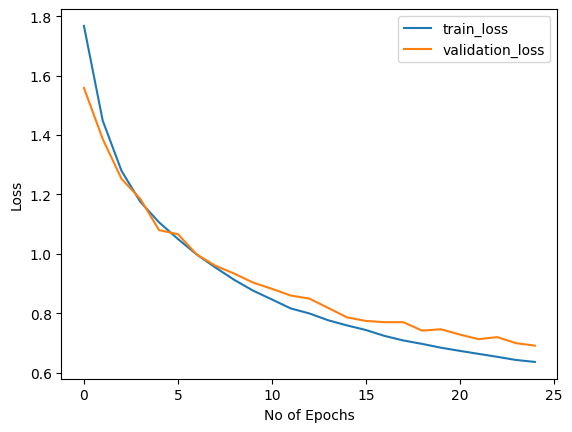

In [ ]:
plt.plot(train_losses_allcnnc_plus, label = 'train_loss')
plt.plot(validation_losses_allcnnc_plus, label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc_allcnnc_plus = accuracy(train_loader_cifar_plus, model_allcnnc_plus)
test_acc_allcnnc_plus = accuracy(test_loader_cifar_plus, model_allcnnc_plus)
validation_acc_allcnnc_plus = accuracy(val_loader_cifar_plus, model_allcnnc_plus)

In [ ]:
print(
    f"Train Accuracy : {train_acc_allcnnc_plus}\nTest Accuracy : {test_acc_allcnnc_plus}\nValidation Accuracy : {validation_acc_allcnnc_plus}"
)

Train Accuracy : 0.792625
Test Accuracy : 0.7471
Validation Accuracy : 0.758


In [ ]:
model_p4allcnnc_plus = P4AllCNNC()
model_p4allcnnc_plus.to(device)

weight_decay = 1e-4

criterion_p4allcnnc_plus = nn.CrossEntropyLoss()
optimizer_p4allcnnc_plus = optim.Adam(model_p4allcnnc_plus.parameters(), lr=0.001, weight_decay=weight_decay)

In [ ]:
train_losses_p4allcnnc_plus, validation_losses_p4allcnnc_plus = batch_gd(
    model_p4allcnnc_plus, criterion_p4allcnnc_plus, optimizer_p4allcnnc_plus, train_loader_cifar_plus, val_loader_cifar_plus, 30
)

Epoch : 1/30 Train_loss:1.926 Validation_loss:1.807 Duration:0:00:58.907139
Epoch : 2/30 Train_loss:1.695 Validation_loss:1.626 Duration:0:00:57.762333
Epoch : 3/30 Train_loss:1.554 Validation_loss:1.512 Duration:0:00:57.653298
Epoch : 4/30 Train_loss:1.456 Validation_loss:1.427 Duration:0:00:58.011105
Epoch : 5/30 Train_loss:1.387 Validation_loss:1.372 Duration:0:00:58.179921
Epoch : 6/30 Train_loss:1.324 Validation_loss:1.317 Duration:0:00:57.981276
Epoch : 7/30 Train_loss:1.276 Validation_loss:1.290 Duration:0:00:57.584948
Epoch : 8/30 Train_loss:1.241 Validation_loss:1.269 Duration:0:00:57.937892
Epoch : 9/30 Train_loss:1.192 Validation_loss:1.183 Duration:0:00:58.233962
Epoch : 10/30 Train_loss:1.145 Validation_loss:1.144 Duration:0:00:57.755388
Epoch : 11/30 Train_loss:1.099 Validation_loss:1.114 Duration:0:00:57.661920
Epoch : 12/30 Train_loss:1.046 Validation_loss:1.065 Duration:0:00:58.045647
Epoch : 13/30 Train_loss:1.011 Validation_loss:1.057 Duration:0:00:58.051551
Epoch : 

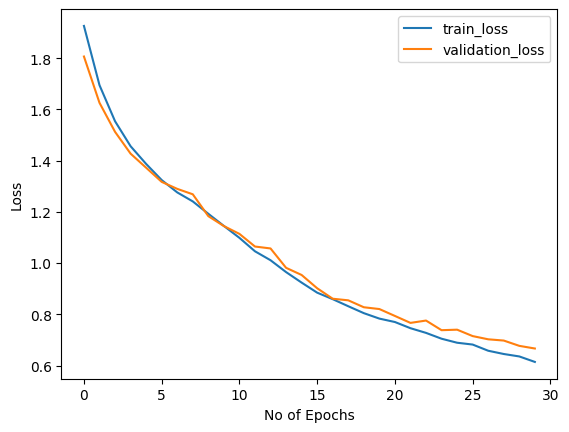

In [ ]:
plt.plot(train_losses_p4allcnnc_plus, label = 'train_loss')
plt.plot(validation_losses_p4allcnnc_plus, label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc_p4allcnnc_plus = accuracy(train_loader_cifar_plus, model_p4allcnnc_plus)
test_acc_p4allcnnc_plus = accuracy(test_loader_cifar_plus, model_p4allcnnc_plus)
validation_acc_p4allcnnc_plus = accuracy(val_loader_cifar_plus, model_p4allcnnc_plus)

In [ ]:
print(
    f"Train Accuracy : {train_acc_p4allcnnc_plus}\nTest Accuracy : {test_acc_p4allcnnc_plus}\nValidation Accuracy : {validation_acc_p4allcnnc_plus}"
)

Train Accuracy : 0.802725
Test Accuracy : 0.764
Validation Accuracy : 0.7724


In [ ]:
model_p4mallcnnc_plus = P4MAllCNNC()
model_p4mallcnnc_plus.to(device)

weight_decay = 1e-4

criterion_p4mallcnnc_plus = nn.CrossEntropyLoss()
optimizer_p4mallcnnc_plus = optim.Adam(model_p4mallcnnc_plus.parameters(), lr=0.001, weight_decay=weight_decay)

In [ ]:
train_losses_p4mallcnnc_plus, validation_losses_p4mallcnnc_plus = batch_gd(
    model_p4mallcnnc_plus, criterion_p4mallcnnc_plus, optimizer_p4mallcnnc_plus, train_loader_cifar_plus, val_loader_cifar_plus, 30
)

Epoch : 1/30 Train_loss:1.928 Validation_loss:1.813 Duration:0:02:58.785778
Epoch : 2/30 Train_loss:1.708 Validation_loss:1.636 Duration:0:02:59.638801
Epoch : 3/30 Train_loss:1.539 Validation_loss:1.481 Duration:0:02:58.695908
Epoch : 4/30 Train_loss:1.422 Validation_loss:1.413 Duration:0:02:59.091198
Epoch : 5/30 Train_loss:1.340 Validation_loss:1.332 Duration:0:02:58.689145
Epoch : 6/30 Train_loss:1.268 Validation_loss:1.252 Duration:0:02:58.852275
Epoch : 7/30 Train_loss:1.208 Validation_loss:1.204 Duration:0:02:59.694104
Epoch : 8/30 Train_loss:1.153 Validation_loss:1.136 Duration:0:02:59.192597
Epoch : 9/30 Train_loss:1.090 Validation_loss:1.106 Duration:0:02:59.872750
Epoch : 10/30 Train_loss:1.039 Validation_loss:1.062 Duration:0:02:59.620697
Epoch : 11/30 Train_loss:1.000 Validation_loss:1.022 Duration:0:02:59.282056
Epoch : 12/30 Train_loss:0.963 Validation_loss:0.980 Duration:0:02:59.503498
Epoch : 13/30 Train_loss:0.923 Validation_loss:0.950 Duration:0:02:58.896040
Epoch : 

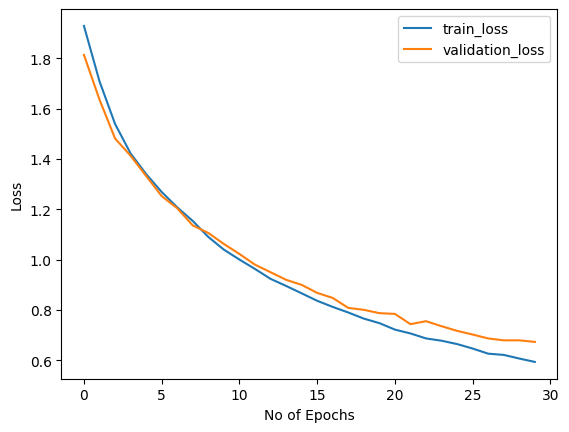

In [ ]:
plt.plot(train_losses_p4mallcnnc_plus, label = 'train_loss')
plt.plot(validation_losses_p4mallcnnc_plus, label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc_p4mallcnnc_plus = accuracy(train_loader_cifar_plus, model_p4mallcnnc_plus)
test_acc_p4mallcnnc_plus = accuracy(test_loader_cifar_plus, model_p4mallcnnc_plus)
validation_acc_p4mallcnnc_plus = accuracy(val_loader_cifar_plus, model_p4mallcnnc_plus)

In [ ]:
print(
    f"Train Accuracy : {train_acc_p4mallcnnc_plus}\nTest Accuracy : {test_acc_p4mallcnnc_plus}\nValidation Accuracy : {validation_acc_p4mallcnnc_plus}"
)

Train Accuracy : 0.80645
Test Accuracy : 0.772
Validation Accuracy : 0.7696


As can be noticed with data augmentation the performances improve for the Group Equivariant CNN but remain pretty much the same for the regular CNN.

The second baseline is a residual network ([He et al., 2016](https://arxiv.org/abs/1512.03385)),
which consists of an initial convolution layer, followed by
three stages of 2n convolution layers using ki filters at stage
i, followed by a final classification layer (6n + 2 layers in
total). The first convolution in each stage i > 1 uses a stride
of 2, so the feature map sizes are 32, 16, and 8 for the three
stages. I use n = 7, ki = 32, 64, 128 yielding a wide
44-layer network called ResNet44.

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, dropout_prob=0.5):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout2d(dropout_prob)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout2d(dropout_prob)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout1(out)
        out = self.bn2(self.conv2(out))
        out = self.dropout2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class ResNet44(nn.Module):
    def __init__(self, n=7, ki=[32, 64, 128], num_classes=10, dropout_prob=0.5):
        super(ResNet44, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout2d(dropout_prob)
        self.stage1 = self._make_stage(16, ki[0], n, stride=1, dropout_prob=dropout_prob)
        self.stage2 = self._make_stage(ki[0], ki[1], n, stride=2, dropout_prob=dropout_prob)
        self.stage3 = self._make_stage(ki[1], ki[2], n, stride=2, dropout_prob=dropout_prob)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(ki[2] * BasicBlock.expansion, num_classes)

    def _make_stage(self, in_channels, out_channels, blocks, stride, dropout_prob):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride, dropout_prob))
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels, dropout_prob=dropout_prob))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout1(out)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
dropout_prob = 0.5
model_ResNet44 = ResNet44(num_classes=10, dropout_prob=dropout_prob)
model_ResNet44.to(device)

weight_decay = 1e-4

criterion_ResNet44 = nn.CrossEntropyLoss()
optimizer_ResNet44 = optim.Adam(model_ResNet44.parameters(), lr=0.001, weight_decay=weight_decay)

In [ ]:
total_params = sum(p.numel() for p in model_ResNet44.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 2631962


In [ ]:
train_losses_ResNet44, validation_losses_ResNet44 = batch_gd(
    model_ResNet44, criterion_ResNet44, optimizer_ResNet44, train_loader_cifar, val_loader_cifar, 45
)

Epoch : 1/45 Train_loss:2.295 Validation_loss:2.119 Duration:0:00:45.719316
Epoch : 2/45 Train_loss:2.054 Validation_loss:2.015 Duration:0:00:42.571653
Epoch : 3/45 Train_loss:1.960 Validation_loss:1.903 Duration:0:00:41.779708
Epoch : 4/45 Train_loss:1.876 Validation_loss:1.840 Duration:0:00:42.677244
Epoch : 5/45 Train_loss:1.812 Validation_loss:1.781 Duration:0:00:42.139653
Epoch : 6/45 Train_loss:1.755 Validation_loss:1.718 Duration:0:00:42.369006
Epoch : 7/45 Train_loss:1.692 Validation_loss:1.644 Duration:0:00:42.150569
Epoch : 8/45 Train_loss:1.636 Validation_loss:1.614 Duration:0:00:42.490149
Epoch : 9/45 Train_loss:1.587 Validation_loss:1.565 Duration:0:00:42.003674
Epoch : 10/45 Train_loss:1.536 Validation_loss:1.493 Duration:0:00:42.270013
Epoch : 11/45 Train_loss:1.489 Validation_loss:1.462 Duration:0:00:42.465952
Epoch : 12/45 Train_loss:1.431 Validation_loss:1.402 Duration:0:00:42.073413
Epoch : 13/45 Train_loss:1.379 Validation_loss:1.362 Duration:0:00:42.826287
Epoch : 

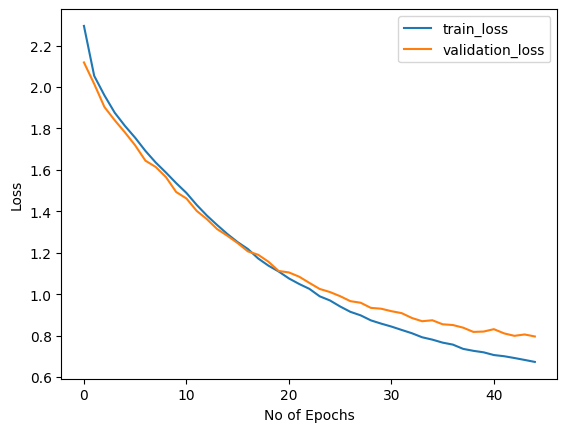

In [ ]:
plt.plot(train_losses_ResNet44, label = 'train_loss')
plt.plot(validation_losses_ResNet44, label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc_ResNet44 = accuracy(train_loader_cifar, model_ResNet44)
test_acc_ResNet44 = accuracy(test_loader_cifar, model_ResNet44)
validation_acc_ResNet44 = accuracy(val_loader_cifar, model_ResNet44)

In [ ]:
print(
    f"Train Accuracy : {train_acc_ResNet44}\nTest Accuracy : {test_acc_ResNet44}\nValidation Accuracy : {validation_acc_ResNet44}"
)

Train Accuracy : 0.77555
Test Accuracy : 0.7345
Validation Accuracy : 0.7243


Again for the P4M equivariant network we need to divide the number of filfers by √8 ≈ 3 in each p4m-convolutional layer. By doing so, we maintain the number of parameters at approximately the same level while increasing the size of the internal representation. To be precise, I employed ki = 11, 23, 45 for p4m-ResNet44.

In [ ]:
class P4MBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, dropout_prob=0.5):
        super(P4MBasicBlock, self).__init__()
        self.conv1 = Group_Convolution_p4m(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=True)
        self.bn1 = EquivariantBatchNorm(out_channels)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.conv2 = Group_Convolution_p4m(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn2 = EquivariantBatchNorm(out_channels)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                Group_Convolution_p4m(in_channels, out_channels, kernel_size=1, stride=stride, bias=True),
                EquivariantBatchNorm(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout1(out)
        out = self.bn2(self.conv2(out))
        out = self.dropout2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class P4MResNet44(nn.Module):
    def __init__(self, n=7, ki=[11, 23, 45], num_classes=10, dropout_prob=0.5):
        super(P4MResNet44, self).__init__()
        self.in_channels = 11
        self.conv1 = Lifting_Convolution_D4(3, 11, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn1 = EquivariantBatchNorm(11)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.stage1 = self._make_stage(11, ki[0], n, stride=1, dropout_prob=dropout_prob)
        self.stage2 = self._make_stage(ki[0], ki[1], n, stride=2, dropout_prob=dropout_prob)
        self.stage3 = self._make_stage(ki[1], ki[2], n, stride=2, dropout_prob=dropout_prob)
        self.linear = nn.Linear(ki[2] * P4MBasicBlock.expansion, num_classes)

    def _make_stage(self, in_channels, out_channels, blocks, stride, dropout_prob):
        layers = []
        layers.append(P4MBasicBlock(in_channels, out_channels, stride, dropout_prob))
        for _ in range(1, blocks):
            layers.append(P4MBasicBlock(out_channels, out_channels, dropout_prob=dropout_prob))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout1(out)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = F.avg_pool3d(out, (6,6,6))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
dropout_prob = 0.3
model_P4MResNet44 = P4MResNet44(num_classes=10, dropout_prob=dropout_prob)
model_P4MResNet44.to(device)

weight_decay = 1e-4

criterion_P4MResNet44 = nn.CrossEntropyLoss()
optimizer_P4MResNet44 = optim.Adam(model_P4MResNet44.parameters(), lr=0.001, weight_decay=weight_decay)

In [ ]:
total_params = sum(p.numel() for p in model_P4MResNet44.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 2619864


In [ ]:
train_losses_P4MResNet44, validation_losses_P4MResNet44 = batch_gd(
    model_P4MResNet44, criterion_P4MResNet44, optimizer_P4MResNet44, train_loader_cifar, val_loader_cifar, 15
)

Epoch : 1/15 Train_loss:1.803 Validation_loss:1.530 Duration:0:07:02.796083
Epoch : 2/15 Train_loss:1.202 Validation_loss:1.001 Duration:0:06:48.120054
Epoch : 3/15 Train_loss:0.861 Validation_loss:0.788 Duration:0:06:47.843261
Epoch : 4/15 Train_loss:0.709 Validation_loss:0.713 Duration:0:06:43.075985
Epoch : 5/15 Train_loss:0.612 Validation_loss:0.620 Duration:0:06:40.795150
Epoch : 6/15 Train_loss:0.541 Validation_loss:0.555 Duration:0:06:40.636914
Epoch : 7/15 Train_loss:0.482 Validation_loss:0.511 Duration:0:06:41.078363
Epoch : 8/15 Train_loss:0.444 Validation_loss:0.493 Duration:0:06:41.602418
Epoch : 9/15 Train_loss:0.408 Validation_loss:0.451 Duration:0:06:41.044441
Epoch : 10/15 Train_loss:0.372 Validation_loss:0.497 Duration:0:06:40.596737
Epoch : 11/15 Train_loss:0.352 Validation_loss:0.438 Duration:0:06:40.300229
Epoch : 12/15 Train_loss:0.326 Validation_loss:0.433 Duration:0:06:40.938982
Epoch : 13/15 Train_loss:0.307 Validation_loss:0.429 Duration:0:06:43.420223
Epoch : 

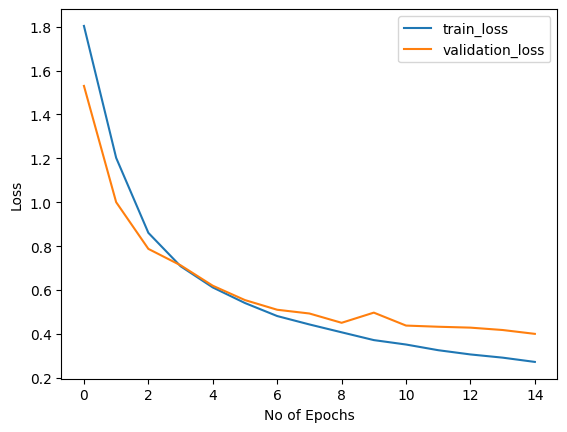

In [ ]:
plt.plot(train_losses_P4MResNet44, label = 'train_loss')
plt.plot(validation_losses_P4MResNet44, label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc_P4MResNet44 = accuracy(train_loader_cifar, model_P4MResNet44)
test_acc_P4MResNet44 = accuracy(test_loader_cifar, model_P4MResNet44)
validation_acc_P4MResNet44 = accuracy(val_loader_cifar, model_P4MResNet44)

In [ ]:
print(
    f"Train Accuracy : {train_acc_P4MResNet44}\nTest Accuracy : {test_acc_P4MResNet44}\nValidation Accuracy : {validation_acc_P4MResNet44}"
)

Train Accuracy : 0.91645
Test Accuracy : 0.8649
Validation Accuracy : 0.8636


Here, the impressive strength of Group Equivariant CNNs is evident!
Using the ResNet44 architecture with comparable parameters, the P4MResNet44 exhibits the best performance among all tested networks on CIFAR10.

However, we need to assess the impact of data augmentation on these two networks. Let's proceed with training and testing them on CIFAR10+.

In [ ]:
dropout_prob = 0.5
model_ResNet44_plus = ResNet44(num_classes=10, dropout_prob=dropout_prob)
model_ResNet44_plus.to(device)

weight_decay = 1e-4

criterion_ResNet44_plus = nn.CrossEntropyLoss()
optimizer_ResNet44_plus = optim.Adam(model_ResNet44_plus.parameters(), lr=0.001, weight_decay=weight_decay)

In [ ]:
train_losses_ResNet44_plus, validation_losses_ResNet44_plus = batch_gd(
    model_ResNet44_plus, criterion_ResNet44_plus, optimizer_ResNet44_plus, train_loader_cifar_plus, val_loader_cifar_plus, 70
)

Epoch : 1/70 Train_loss:2.293 Validation_loss:2.133 Duration:0:00:34.335429
Epoch : 2/70 Train_loss:2.069 Validation_loss:2.041 Duration:0:00:32.586788
Epoch : 3/70 Train_loss:1.973 Validation_loss:1.943 Duration:0:00:32.783897
Epoch : 4/70 Train_loss:1.910 Validation_loss:1.895 Duration:0:00:32.780474
Epoch : 5/70 Train_loss:1.865 Validation_loss:1.859 Duration:0:00:32.683728
Epoch : 6/70 Train_loss:1.819 Validation_loss:1.815 Duration:0:00:32.635846
Epoch : 7/70 Train_loss:1.783 Validation_loss:1.770 Duration:0:00:32.912012
Epoch : 8/70 Train_loss:1.741 Validation_loss:1.751 Duration:0:00:32.662207
Epoch : 9/70 Train_loss:1.707 Validation_loss:1.703 Duration:0:00:32.604120
Epoch : 10/70 Train_loss:1.668 Validation_loss:1.657 Duration:0:00:33.435438
Epoch : 11/70 Train_loss:1.624 Validation_loss:1.617 Duration:0:00:32.841583
Epoch : 12/70 Train_loss:1.589 Validation_loss:1.592 Duration:0:00:32.635290
Epoch : 13/70 Train_loss:1.549 Validation_loss:1.559 Duration:0:00:32.687136
Epoch : 

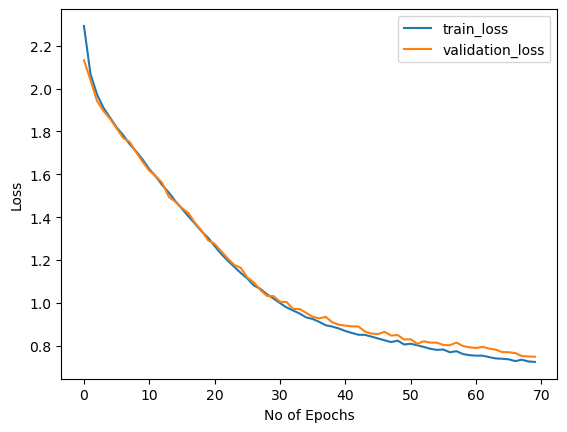

In [ ]:
plt.plot(train_losses_ResNet44_plus, label = 'train_loss')
plt.plot(validation_losses_ResNet44_plus, label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc_ResNet44_plus = accuracy(train_loader_cifar_plus, model_ResNet44_plus)
test_acc_ResNet44_plus = accuracy(test_loader_cifar_plus, model_ResNet44_plus)
validation_acc_ResNet44_plus = accuracy(val_loader_cifar_plus, model_ResNet44_plus)

In [ ]:
print(
    f"Train Accuracy : {train_acc_ResNet44_plus}\nTest Accuracy : {test_acc_ResNet44_plus}\nValidation Accuracy : {validation_acc_ResNet44_plus}"
)

Train Accuracy : 0.754125
Test Accuracy : 0.7508
Validation Accuracy : 0.7422


In [ ]:
torch.save(model_ResNet44_plus.state_dict() , 'model_ResNet44_plus.pt')

In [ ]:
dropout_prob = 0.3
model_P4MResNet44_plus = P4MResNet44(num_classes=10, dropout_prob=dropout_prob)
model_P4MResNet44_plus.to(device)

weight_decay = 1e-4

criterion_P4MResNet44_plus = nn.CrossEntropyLoss()
optimizer_P4MResNet44_plus = optim.Adam(model_P4MResNet44_plus.parameters(), lr=0.001, weight_decay=weight_decay)

In [ ]:
train_losses_P4MResNet44_plus, validation_losses_P4MResNet44_plus = batch_gd(
    model_P4MResNet44_plus, criterion_P4MResNet44_plus, optimizer_P4MResNet44_plus, train_loader_cifar_plus, val_loader_cifar_plus, 25
)

Epoch : 1/25 Train_loss:1.908 Validation_loss:1.760 Duration:0:07:43.001200
Epoch : 2/25 Train_loss:1.619 Validation_loss:1.479 Duration:0:07:42.555682
Epoch : 3/25 Train_loss:1.244 Validation_loss:1.089 Duration:0:07:42.236454
Epoch : 4/25 Train_loss:0.969 Validation_loss:0.917 Duration:0:07:43.205768
Epoch : 5/25 Train_loss:0.835 Validation_loss:0.824 Duration:0:07:44.301591
Epoch : 6/25 Train_loss:0.741 Validation_loss:0.729 Duration:0:07:42.004111
Epoch : 7/25 Train_loss:0.673 Validation_loss:0.654 Duration:0:07:43.945777
Epoch : 8/25 Train_loss:0.612 Validation_loss:0.607 Duration:0:07:42.071850
Epoch : 9/25 Train_loss:0.571 Validation_loss:0.572 Duration:0:07:38.925145
Epoch : 10/25 Train_loss:0.530 Validation_loss:0.562 Duration:0:07:38.221452
Epoch : 11/25 Train_loss:0.495 Validation_loss:0.510 Duration:0:07:37.703049
Epoch : 12/25 Train_loss:0.467 Validation_loss:0.509 Duration:0:07:38.026660
Epoch : 13/25 Train_loss:0.449 Validation_loss:0.514 Duration:0:07:37.596830
Epoch : 

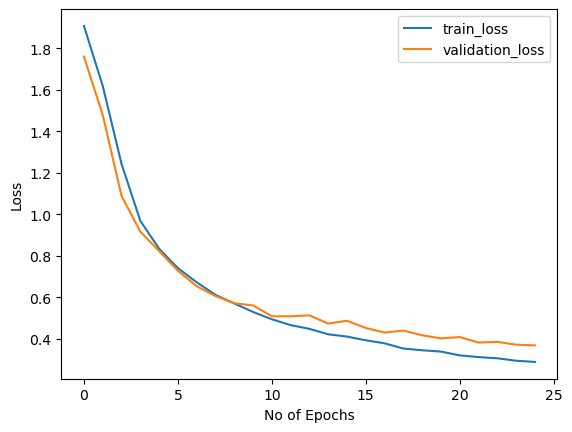

In [ ]:
plt.plot(train_losses_P4MResNet44_plus, label = 'train_loss')
plt.plot(validation_losses_P4MResNet44_plus, label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc_P4MResNet44_plus = accuracy(train_loader_cifar_plus, model_P4MResNet44_plus)
test_acc_P4MResNet44_plus = accuracy(test_loader_cifar_plus, model_P4MResNet44_plus)
validation_acc_P4MResNet44_plus = accuracy(val_loader_cifar_plus, model_P4MResNet44_plus)

In [ ]:
print(
    f"Train Accuracy : {train_acc_P4MResNet44_plus}\nTest Accuracy : {test_acc_P4MResNet44_plus}\nValidation Accuracy : {validation_acc_P4MResNet44_plus}"
)

Train Accuracy : 0.90975
Test Accuracy : 0.8792
Validation Accuracy : 0.8764


In [ ]:
torch.save(model_P4MResNet44_plus.state_dict() , 'model_P4MResNet44_plus.pt')

As expected on CIFRA10+ the performances got even better expecially for P4MResNet44.

Let's compare the performances of all the models we saw for CIFAR10 and CIFAR10+ (please note that these values may vary slightly between different training runs):

<table>
  <tr>
    <th>Network</th>
    <th>CIFAR10</th>
    <th>CIFAR10+</th>
    <th>Parameters</th>
  </tr>
  <tr>
    <td>AllCNNC</td>
    <td>0.7507</td>
    <td>0.7498</td>
    <td>1372254</td>
  </tr>
  <tr>
    <td>P4AllCNNC</td>
    <td>0.7595</td>
    <td> 0.775</td>
    <td>1371006</td>
  </tr>
  <tr>
    <td>P4MAllCNNC</td>
    <td>0.7696</td>
    <td>0.772</td>
    <td>1219678</td>
  </tr>
  <tr>
    <td>ResNet44</td>
    <td>0.7345</td>
    <td>0.7508</td>
    <td>2631962</td>
  </tr>
  <tr>
    <td>P4MResNet44</td>
    <td>0.8649</td>
    <td> 0.8792</td>
    <td>2619864</td>
  </tr>
</table>

We can derive several important insights from these experiments.

Firstly, the choice of the CIFAR10 dataset is intriguing because it is not perfectly symmetric, yet G-CNNs show significant accuracy improvements, suggesting that full symmetry is not necessary for G-convolutions to be advantageous.

Furthermore, it is worth noting that G-CNNs benefit from data augmentation similarly to regular convolutional networks, especially when using augmentations from a group larger than G. Applying flips and small translations consistently enhances the results for the p4- and p4m- CNN models.

---

Now is the time to reassess the robustness of G-CNNs against adversarial attacks, using the FGSM attack. I will continue to compare their performance with a regular CNNs.

The best performing models on CIFAR10+ were ResNet44 and P4MResNet44. However, due to limited computational resources (especially since P4MResNet44 takes a significant amount of time to be perturbed), I have chosen to evaluate the robustness against adversarial attacks of AllCNNC and P4MAllCNNC.

In [ ]:
model_allcnnc_plus = AllCNNC().to(device)
model_allcnnc_plus.load_state_dict(torch.load("model_allcnnc_plus.pt", map_location=device))
model_allcnnc_plus.eval()

AllCNNC(
  (features): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.7, inplace=False)
    (11): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [ ]:
model_p4mallcnnc_plus = P4MAllCNNC().to(device)
model_p4mallcnnc_plus.load_state_dict(torch.load("model_p4mallcnnc_plus.pt", map_location=device))
model_p4mallcnnc_plus.eval()

P4MAllCNNC(
  (features): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Lifting_Convolution_D4()
    (2): EquivariantBatchNorm(
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ReLU()
    (4): Group_Convolution_p4m()
    (5): ReLU()
    (6): EquivariantBatchNorm(
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (7): Group_Convolution_p4m()
    (8): ReLU()
    (9): EquivariantBatchNorm(
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (10): Dropout(p=0.7, inplace=False)
    (11): Group_Convolution_p4m()
    (12): EquivariantBatchNorm(
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (13): ReLU()
    (14): Group_Convolution_p4m()
    (15): EquivariantBatchNorm(
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [ ]:
test_loader_cifar_plus_aa = torch.utils.data.DataLoader(test_data_cifar_plus, batch_size=1)

The FGSM adversarial attack is more effective on RGB images than grayscale images due to the higher dimensionality and richer color information in RGB images. RGB images have three color channels, providing more parameters for manipulation. Deep learning models trained on RGB images are more sensitive to changes in color, making them susceptible to adversarial perturbations.

This is the reason why the values of epsilon this time are smaller than the ones used for Rotated MNIST.

In [ ]:
vnum_display = 5
accuracies_allcnnc_plus = []
accuracies_p4mallcnnc_plus = []
all_adv_examples_allcnnc_plus = []
all_adv_examples_p4mallcnnc_plus = []
model_name1 = "allcnnc_plus"
model_name2 = "p4mallcnnc_plus"
epsilons = [.001, .01, .1]

for epsilon in epsilons:
    accuracy_allcnnc_plus, adv_examples_allcnnc_plus = test(model_allcnnc_plus, model_name1, test_loader_cifar_plus_aa, epsilon, device, num_display)
    accuracies_allcnnc_plus.append(accuracy_allcnnc_plus)
    all_adv_examples_allcnnc_plus.append(adv_examples_allcnnc_plus)

    accuracy_p4mallcnnc_plus, adv_examples_p4mallcnnc_plus = test(model_p4mallcnnc_plus, model_name2, test_loader_cifar_plus_aa, epsilon, device, num_display)
    accuracies_p4mallcnnc_plus.append(accuracy_p4mallcnnc_plus)
    all_adv_examples_p4mallcnnc_plus.append(adv_examples_p4mallcnnc_plus)

Epsilon: 0.001, Model: allcnnc_plus, Accuracy: 0.728
Epsilon: 0.001, Model: p4mallcnnc_plus, Accuracy: 0.749
Epsilon: 0.01, Model: allcnnc_plus, Accuracy: 0.277
Epsilon: 0.01, Model: p4mallcnnc_plus, Accuracy: 0.245
Epsilon: 0.1, Model: allcnnc_plus, Accuracy: 0.068
Epsilon: 0.1, Model: p4mallcnnc_plus, Accuracy: 0.088


<ipython-input-134-08e32f08ee39>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


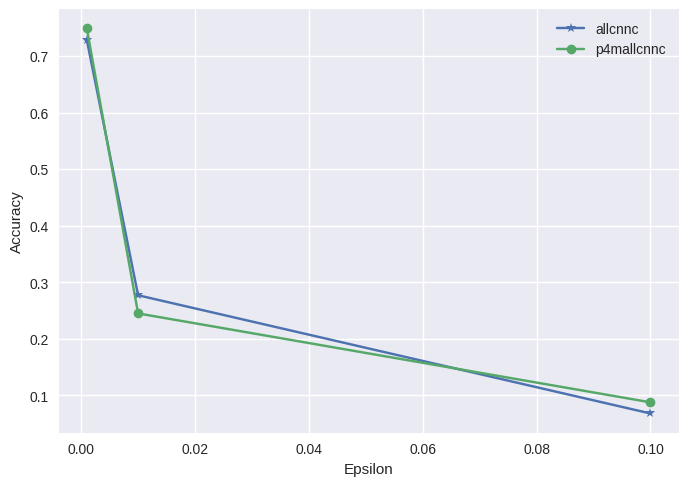

In [ ]:
plt.style.use("seaborn")
plt.plot(epsilons, accuracies_allcnnc_plus, "*-", label="allcnnc")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.plot(epsilons, accuracies_p4mallcnnc_plus, "o-", label="p4mallcnnc")
plt.legend()
plt.show()

In this case, the performances of AllCNNC and P4MAllCNNC are nearly identical, indicating little difference between the two models. This similarity is likely due to the fact that the non-perturbed models also exhibit very similar performances.

We can observe that, in contrast to grayscale images like those in Rotated MNIST, even very small perturbations generated with epsilon equal to 0.1 result in the generation of images that are severely distorted and almost unrecognizable, even to humans.

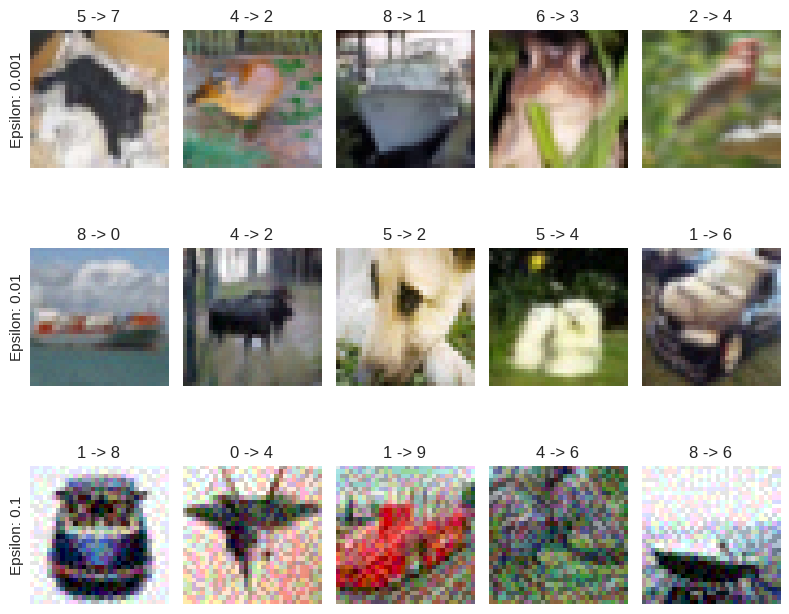

In [ ]:
nrows = len(epsilons)
ncols = num_display

fig, ax = plt.subplots(3, 5, figsize=(8, 7))

for row in range(nrows):
    for col in range(ncols):
        label, perturbed_pred, perturbed_image = all_adv_examples_myp4cnn_cifar_plus[row][col]
        axis = ax[row, col]
        perturbed_image_cpu = perturbed_image.cpu()
        perturbed_image_np = perturbed_image_cpu.detach().numpy()
        perturbed_image_np = np.transpose(perturbed_image_np, (1, 2, 0))

        axis.imshow(perturbed_image_np)
        axis.set_title(f"{label} -> {perturbed_pred}")
        clean_axis(axis)
        if col == 0:
            axis.set_ylabel(f"Epsilon: {epsilons[row]}")
plt.tight_layout()
plt.show()

# **5. Experiments on Plant Leaves**

"Plant Leaves" is a novel dataset that combines classes from PlantVillage's healthy classes with additional classes I collected (namely "Olive_healthy" and "Bread_Bean_healthy"). The dataset consists of 12 classes and contains approximately 13k RGB images.

These the classes:
1. Apple___healthy
2. Blueberry___healthy
3. Bread_Bean_healthy
4. Cherry___healthy
5. Corn___healthy
6. Grape___healthy
7. Olive_healthy
8. Peach___healthy
9. Pepper,_bell___healthy
10. Raspberry___healthy
11. Strawberry___healthy
12. Tomato___healthy

I wanted to explore the potential of using group equivariant CNNs for leaf classification, as they are capable of effectively leveraging symmetries. Leaves frequently exhibit various symmetries, including bilateral, radial, palmate, or pinnate structures. Additionally, some leaves display fractal symmetry with fascinating self-replicating patterns. It's important to consider that leaf shape and symmetry can vary significantly across plant species due to their unique evolutionary history and environmental influences.

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.4976, 0.5324, 0.4659], [0.1710, 0.1327, 0.1837])
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.4976, 0.5324, 0.4659], [0.1710, 0.1327, 0.1837])
])

dataset = ImageFolder(root="/content/dataset/Plant_Leaves", transform=None)

indices = list(range(len(dataset)))
split = int(np.floor(0.85 * len(dataset)))
validation = int(np.floor(0.70 * split))
np.random.shuffle(indices)
train_indices, validation_indices, test_indices = (indices[:validation], indices[validation:split], indices[split:])

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_dataset = ImageFolder(root="/content/dataset/Plant_Leaves", transform=train_transform)
validation_dataset = ImageFolder(root="/content/dataset/Plant_Leaves", transform=test_transform)
test_dataset = ImageFolder(root="/content/dataset/Plant_Leaves", transform=test_transform)

batch_size = 128

train_loader_leaves = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
test_loader_leaves = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)
validation_loader_leaves = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, sampler=validation_sampler)

In [ ]:
print(f"length of train size: {validation}")
print(f"length of validation size: {split - validation}")
print(f"length of test size: {len(dataset)-validation}")

length of train size: 6328
length of validation size: 2713
length of test size: 4309


In [ ]:
targets_size = len(dataset.class_to_idx)
print("The number of classes is:", targets_size)

The number of classes is: 12


We have already showed some instances from this dataset in section 2. However, let's proceed with visualizing additional images from the dataset along with their corresponding labels:

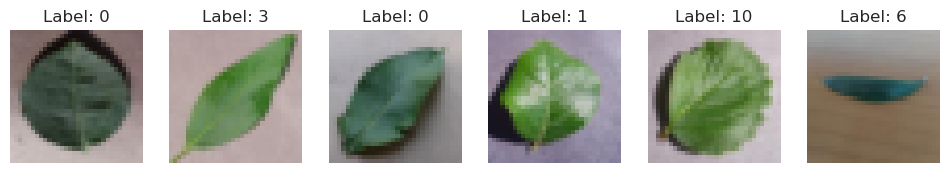

In [ ]:
num_images_to_plot = 6
images_to_plot = []
labels_to_plot = []

for i, (image, label) in enumerate(test_loader_leaves):
    if i >= num_images_to_plot:
        break
    images_to_plot.append(image[0])
    labels_to_plot.append(label[0])

plt.figure(figsize=(12, 8))
for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i+1)
    plt.imshow(np.transpose(images_to_plot[i], (1, 2, 0)))
    plt.title(f"Label: {labels_to_plot[i]}")
    plt.axis('off')

plt.show()

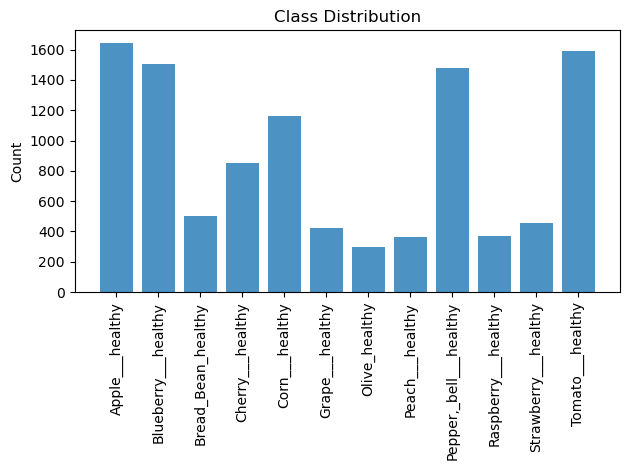

In [ ]:
def plot_class_distribution(dataset):
    num_classes = len(dataset.classes)
    class_counts = [0] * num_classes

    for _, label in dataset:
        class_counts[label] += 1

    class_names = dataset.classes
    y_pos = np.arange(num_classes)

    plt.bar(y_pos, class_counts, align='center', alpha=0.8)
    plt.xticks(y_pos, class_names, rotation='vertical')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.tight_layout()
    plt.show()

plot_class_distribution(dataset)

This time, the dataset is slightly imbalanced. To mitigate this issue, I applied data augmentation with transformations similar to those used in CIFAR10+.

I will train and test two baseline architectures on this dataset.

The first architecture is ResNet44, along with its equivariant counterpart, P4MResNet44. I have maintained everything, from the parameters to the architecture, just as in the CIFAR10 and CIFAR10+ experiments.

In [ ]:
dropout_prob = 0.5
model_ResNet44_leaves = ResNet44(num_classes=12, dropout_prob=dropout_prob)
model_ResNet44_leaves.to(device)

weight_decay = 1e-4

criterion_ResNet44_leaves = nn.CrossEntropyLoss()
optimizer_ResNet44_leaves = optim.Adam(model_ResNet44_leaves.parameters(), lr=0.001, weight_decay=weight_decay)

In [ ]:
train_losses_ResNet44_leaves, validation_losses_ResNet44_leaves = batch_gd(
    model_ResNet44_leaves, criterion_ResNet44_leaves, optimizer_ResNet44_leaves, train_loader_leaves, validation_loader_leaves, 100
)

Epoch : 1/100 Train_loss:2.502 Validation_loss:2.373 Duration:0:00:18.599438
Epoch : 2/100 Train_loss:2.298 Validation_loss:2.225 Duration:0:00:18.125219
Epoch : 3/100 Train_loss:2.180 Validation_loss:2.126 Duration:0:00:17.491458
Epoch : 4/100 Train_loss:2.102 Validation_loss:2.094 Duration:0:00:18.377335
Epoch : 5/100 Train_loss:2.021 Validation_loss:1.956 Duration:0:00:17.223418
Epoch : 6/100 Train_loss:1.909 Validation_loss:1.866 Duration:0:00:17.763230
Epoch : 7/100 Train_loss:1.851 Validation_loss:1.806 Duration:0:00:17.538243
Epoch : 8/100 Train_loss:1.773 Validation_loss:1.752 Duration:0:00:17.416493
Epoch : 9/100 Train_loss:1.714 Validation_loss:1.639 Duration:0:00:17.545077
Epoch : 10/100 Train_loss:1.654 Validation_loss:1.561 Duration:0:00:17.157035
Epoch : 11/100 Train_loss:1.568 Validation_loss:1.552 Duration:0:00:17.754971
Epoch : 12/100 Train_loss:1.533 Validation_loss:1.433 Duration:0:00:16.919328
Epoch : 13/100 Train_loss:1.477 Validation_loss:1.427 Duration:0:00:17.40

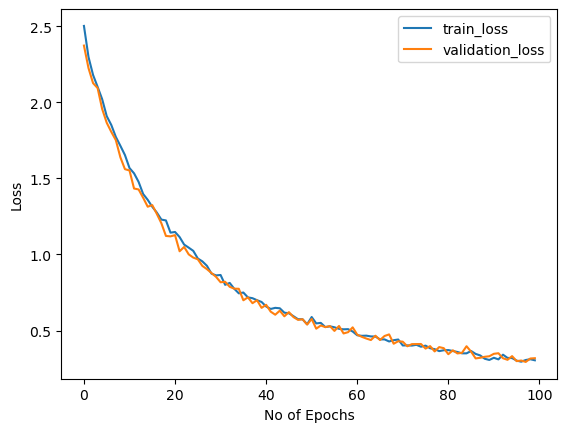

In [ ]:
plt.plot(train_losses_ResNet44_leaves, label = 'train_loss')
plt.plot(validation_losses_ResNet44_leaves, label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc_ResNet44_leaves = accuracy(train_loader_leaves, model_ResNet44_leaves)
test_acc_ResNet44_leaves = accuracy(test_loader_leaves, model_ResNet44_leaves)
validation_acc_ResNet44_leaves = accuracy(validation_loader_leaves, model_ResNet44_leaves)

In [ ]:
print(
    f"Train Accuracy : {train_acc_ResNet44_leaves}\nTest Accuracy : {test_acc_ResNet44_leaves}\nValidation Accuracy : {validation_acc_ResNet44_leaves}"
)

Train Accuracy : 0.8958596713021492
Test Accuracy : 0.893483709273183
Validation Accuracy : 0.8912642830814597


In [ ]:
dropout_prob = 0.3
model_P4MResNet44_leaves = P4MResNet44(num_classes=12, dropout_prob=dropout_prob)
model_P4MResNet44_leaves.to(device)

weight_decay = 1e-4

criterion_P4MResNet44_leaves = nn.CrossEntropyLoss()
optimizer_P4MResNet44_leaves = optim.Adam(model_P4MResNet44_leaves.parameters(), lr=0.001, weight_decay=weight_decay)

In [ ]:
train_losses_P4MResNet44_leaves, validation_losses_P4MResNet44_leaves = batch_gd(
    model_P4MResNet44_leaves, criterion_P4MResNet44_leaves, optimizer_P4MResNet44_leaves, train_loader_leaves, validation_loader_leaves, 30
)

Epoch : 1/30 Train_loss:2.166 Validation_loss:1.749 Duration:0:01:34.747713
Epoch : 2/30 Train_loss:1.443 Validation_loss:1.242 Duration:0:01:35.203360
Epoch : 3/30 Train_loss:1.097 Validation_loss:0.994 Duration:0:01:35.762414
Epoch : 4/30 Train_loss:0.876 Validation_loss:0.738 Duration:0:01:36.067161
Epoch : 5/30 Train_loss:0.695 Validation_loss:0.731 Duration:0:01:35.757350
Epoch : 6/30 Train_loss:0.587 Validation_loss:0.542 Duration:0:01:35.680732
Epoch : 7/30 Train_loss:0.468 Validation_loss:0.446 Duration:0:01:35.959107
Epoch : 8/30 Train_loss:0.443 Validation_loss:0.404 Duration:0:01:35.429996
Epoch : 9/30 Train_loss:0.421 Validation_loss:0.383 Duration:0:01:34.808942
Epoch : 10/30 Train_loss:0.319 Validation_loss:0.312 Duration:0:01:34.885847
Epoch : 11/30 Train_loss:0.302 Validation_loss:0.300 Duration:0:01:34.653276
Epoch : 12/30 Train_loss:0.263 Validation_loss:0.284 Duration:0:01:34.110342
Epoch : 13/30 Train_loss:0.230 Validation_loss:0.230 Duration:0:01:35.225797
Epoch : 

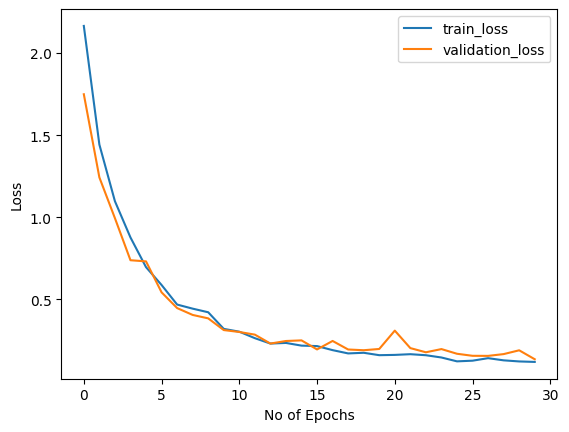

In [ ]:
plt.plot(train_losses_P4MResNet44_leaves, label = 'train_loss')
plt.plot(validation_losses_P4MResNet44_leaves, label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc_P4MResNet44_leaves = accuracy(train_loader_leaves, model_P4MResNet44_leaves)
test_acc_P4MResNet44_leaves = accuracy(test_loader_leaves, model_P4MResNet44_leaves)
validation_acc_P4MResNet44_leaves = accuracy(validation_loader_leaves, model_P4MResNet44_leaves)

In [ ]:
print(
    f"Train Accuracy : {train_acc_P4MResNet44_leaves}\nTest Accuracy : {test_acc_P4MResNet44_leaves}\nValidation Accuracy : {validation_acc_P4MResNet44_leaves}"
)

Train Accuracy : 0.961441213653603
Test Accuracy : 0.9530075187969925
Validation Accuracy : 0.9579800958348691


Also in this case the Group Equivariant CNN led to better performances.

The second architecture, known as MyP4CNN in its group equivariant counterpart, is structured as follows: it starts with a first lifting layer that has 8 output channels, the network then proceeds with 4 group convolutions. These convolutions have output channels of 16, 32, 64, and 128, respectively. All convolutions utilize a kernel size of 3, padding of 1, and stride of 1, and they also incorporate bias. Following each convolutional layer, MaxPool3d, ReLU activation functions, equivariant batch norm and dropout are applied.
The pooling layers are designed with specific configurations: the first three pooling layers have a kernel size of (1, 3, 3), a stride of (1, 2, 2), and a padding of (0, 1, 1). The last pooling layer, however, uses a kernel size of (4, 3, 3), a stride of (1, 1, 1), and no padding (padding (0, 0, 0)).
To complete the architecture, the features extracted from the convolutional network are fed into a linear layer, enabling the classification of the input into 12 classes.

For its benchmark CNN (called myCNN) I replaced each p4-convolution with a simple convolution, MaxPool3d layers with  MaxPool32d layers, each equivariant batch norm layer with BatchNorm2d. The number of filters was multiplied by
2 (so as to keep the number of parameters approximately
similar to the ones of MyP4CNN).

In [ ]:
class MyCNN(torch.nn.Module):
    def __init__(self, n_classes=12):
        super(MyCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1, bias=True),
            nn.Conv2d(8, 32, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=0),
            nn.ReLU()
        )
        self.linear = nn.Linear(256 * 2 * 2, n_classes)

    def forward(self, input):
        out = self.conv_layers(input)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = F.log_softmax(out, dim=1)
        return out


model_mycnn = MyCNN()
model_mycnn.to(device)

criterion_mycnn = nn.CrossEntropyLoss()
optimizer_mycnn = optim.Adam(model_mycnn.parameters(), lr=0.0001)

In [ ]:
total_params = sum(p.numel() for p in model_mycnn.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 403340


In [ ]:
train_losses_mycnn, validation_losses_mycnn = batch_gd(
    model_mycnn, criterion_mycnn, optimizer_mycnn, train_loader_leaves, validation_loader_leaves, 40
)

Epoch : 1/40 Train_loss:1.959 Validation_loss:1.578 Duration:0:00:15.336656
Epoch : 2/40 Train_loss:1.234 Validation_loss:1.041 Duration:0:00:14.989000
Epoch : 3/40 Train_loss:0.872 Validation_loss:0.833 Duration:0:00:14.731614
Epoch : 4/40 Train_loss:0.707 Validation_loss:0.664 Duration:0:00:14.977864
Epoch : 5/40 Train_loss:0.600 Validation_loss:0.587 Duration:0:00:15.646421
Epoch : 6/40 Train_loss:0.526 Validation_loss:0.514 Duration:0:00:14.639013
Epoch : 7/40 Train_loss:0.475 Validation_loss:0.469 Duration:0:00:14.780961
Epoch : 8/40 Train_loss:0.420 Validation_loss:0.428 Duration:0:00:14.529835
Epoch : 9/40 Train_loss:0.389 Validation_loss:0.399 Duration:0:00:14.669762
Epoch : 10/40 Train_loss:0.361 Validation_loss:0.363 Duration:0:00:15.444703
Epoch : 11/40 Train_loss:0.339 Validation_loss:0.357 Duration:0:00:14.860994
Epoch : 12/40 Train_loss:0.316 Validation_loss:0.352 Duration:0:00:14.501451
Epoch : 13/40 Train_loss:0.303 Validation_loss:0.308 Duration:0:00:14.475558
Epoch : 

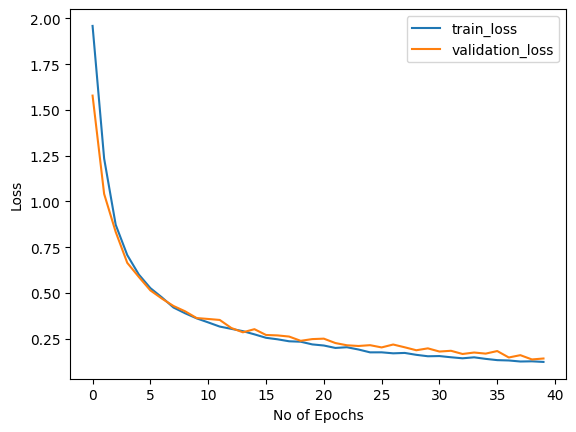

In [ ]:
plt.plot(train_losses_mycnn, label = 'train_loss')
plt.plot(validation_losses_mycnn, label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc_mycnn = accuracy(train_loader_leaves, model_mycnn)
test_acc_mycnn = accuracy(test_loader_leaves, model_mycnn)
validation_acc_mycnn = accuracy(validation_loader_leaves, model_mycnn)

In [ ]:
print(
    f"Train Accuracy : {train_acc_mycnn}\nTest Accuracy : {test_acc_mycnn}\nValidation Accuracy : {validation_acc_mycnn}"
)

Train Accuracy : 0.9623893805309734
Test Accuracy : 0.9611528822055138
Validation Accuracy : 0.9472908219683007


In [ ]:
torch.save(model_mycnn.state_dict() , 'model_mycnn.pt')

In [ ]:
class MyP4CNN(torch.nn.Module):
    def __init__(self, n_classes=12):
        super(MyP4CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            Lifting_Convolution_C4(3, 8, kernel_size=3, padding=1, bias=True),
            Group_Convolution_p4(8, 16, kernel_size=3, padding=1, bias=True),
            EquivariantBatchNorm(16),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Dropout(0.3),

            Group_Convolution_p4(16, 32, kernel_size=3, padding=1, bias=True),
            EquivariantBatchNorm(32),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Dropout(0.3),

            Group_Convolution_p4(32, 64, kernel_size=3, padding=1, bias=True),
            EquivariantBatchNorm(64),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Dropout(0.3),

            Group_Convolution_p4(64, 128, kernel_size=3, padding=1, bias=True),
            EquivariantBatchNorm(128),
            nn.MaxPool3d(kernel_size=(4, 3, 3), stride=(1, 1, 1), padding=(0, 0, 0)),
            nn.ReLU()
        )
        self.linear = nn.Linear(128 * 2 * 2, n_classes)

    def forward(self, input):
        out = self.conv_layers(input)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = F.log_softmax(out, dim=1)
        return out


model_myp4cnn = MyP4CNN()
model_myp4cnn.to(device)

criterion_myp4cnn = nn.CrossEntropyLoss()
optimizer_myp4cnn = optim.Adam(model_myp4cnn.parameters(), lr=0.0001)

In [ ]:
total_params = sum(p.numel() for p in model_myp4cnn.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 398780


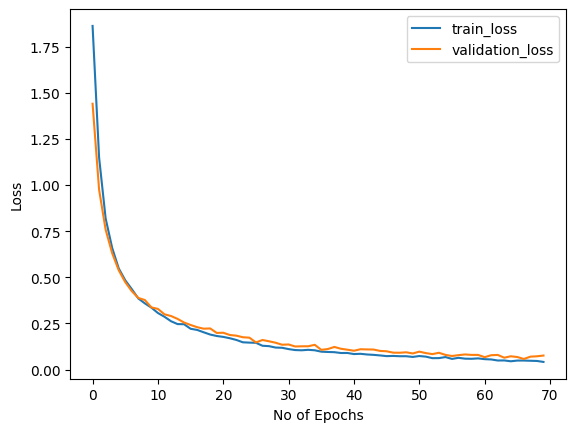

In [ ]:
plt.plot(train_losses_myp4cnn, label = 'train_loss')
plt.plot(validation_losses_myp4cnn, label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc_myp4cnn = accuracy(train_loader_leaves, model_myp4cnn)
test_acc_myp4cnn = accuracy(test_loader_leaves, model_myp4cnn)
validation_acc_myp4cnn = accuracy(validation_loader_leaves, model_myp4cnn)

In [ ]:
print(
    f"Train Accuracy : {train_acc_myp4cnn}\nTest Accuracy : {test_acc_myp4cnn}\nValidation Accuracy : {validation_acc_myp4cnn}"
)

Train Accuracy : 0.9859355246523388
Test Accuracy : 0.9855889724310777
Validation Accuracy : 0.9808330261702912


In [ ]:
torch.save(model_myp4cnn.state_dict() , 'model_myp4cnn.pt')

The performance of MyP4CNN is outstanding, reaching more than 98% accuracy on the test set. MyCNN also performs very well but doesn't reach such heights.

Let's compare the performances of all the models we saw for Plant Leaves (please note that these values may vary slightly between different training runs):

<table>
  <tr>
    <th>Network</th>
    <th>Train accuracy</th>
    <th>Validation accuracy</th>
    <th>Test accuracy</th>
    <th>Parameters</th>
  </tr>
  <tr>
    <td>ResNet44</td>
    <td>0.8958</td>
    <td>0.89126</td>
    <td>0.8934</td>
    <td>2631962</td>
  </tr>
  <tr>
    <td>P4MResNet44</td>
    <td>0.9614</td>
    <td>0.957</td>
    <td>0.9530</td>
    <td>2619864</td>
  </tr>
   <tr>
    <td>MyCNN</td>
    <td>0.962</td>
    <td>0.9472</td>
    <td>0.9611</td>
    <td>403340</td>
  </tr>
  <tr>
    <td>MyP4CNN</td>
    <td>0.9859</td>
    <td>0.9808</td>
    <td>0.9855</td>
    <td>398780</td>
  </tr>
</table>

The results obtained by the group equivariant networks are outstanding, outperforming the vanilla CNNs.

This is an interesting case where a less complex architecture performs better than one with more parameters. It is likely that MyP4CNN is better suited for this specific task, which explains the superior performance.



---



Let's now check the robustness to adversarial attacks of MyP4CNN and MyCNN.

In [ ]:
model_mycnn = MyCNN().to(device)
model_mycnn.load_state_dict(torch.load("model_mycnn.pt", map_location=device))
model_mycnn.eval()

MyCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (9): ReLU()
    (10): Dropout(p=0.3, inplace=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (14): ReLU()
    (15): Dropo

In [ ]:
model_myp4cnn = MyP4CNN().to(device)
model_myp4cnn.load_state_dict(torch.load("model_myp4cnn.pt", map_location=device))
model_myp4cnn.eval()

MyP4CNN(
  (conv_layers): Sequential(
    (0): Lifting_Convolution_C4()
    (1): Group_Convolution_p4()
    (2): EquivariantBatchNorm(
      (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Group_Convolution_p4()
    (7): EquivariantBatchNorm(
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (9): ReLU()
    (10): Dropout(p=0.3, inplace=False)
    (11): Group_Convolution_p4()
    (12): EquivariantBatchNorm(
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (13): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, 

In [ ]:
test_loader_leaves_aa = torch.utils.data.DataLoader(test_dataset, batch_size=1, sampler=test_sampler)

In [ ]:
num_display = 5
accuracies_mycnn = []
accuracies_myp4cnn = []
all_adv_examples_mycnn = []
all_adv_examples_myp4cnn = []
model_name1 = "mycnn"
model_name2 = "myp4cnn"
epsilons = [.001, .01, .1]

for epsilon in epsilons:
    accuracy_mycnn, adv_examples_mycnn = test(model_mycnn, model_name1, test_loader_leaves_aa, epsilon, device, num_display)
    accuracies_mycnn.append(accuracy_mycnn)
    all_adv_examples_mycnn.append(adv_examples_mycnn)

    accuracy_myp4cnn, adv_examples_myp4cnn = test(model_myp4cnn, model_name2, test_loader_leaves_aa, epsilon, device, num_display)
    accuracies_myp4cnn.append(accuracy_myp4cnn)
    all_adv_examples_myp4cnn.append(adv_examples_myp4cnn)

Epsilon: 0.001, Model: mycnn, Accuracy: 0.691
Epsilon: 0.001, Model: myp4cnn, Accuracy: 0.923
Epsilon: 0.01, Model: mycnn, Accuracy: 0.384
Epsilon: 0.01, Model: myp4cnn, Accuracy: 0.553
Epsilon: 0.1, Model: mycnn, Accuracy: 0.044
Epsilon: 0.1, Model: myp4cnn, Accuracy: 0.035


The values for epsilon are the same as those used for the CIFAR10 experiments on adversarial attacks.

<ipython-input-121-25cf331f26a6>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


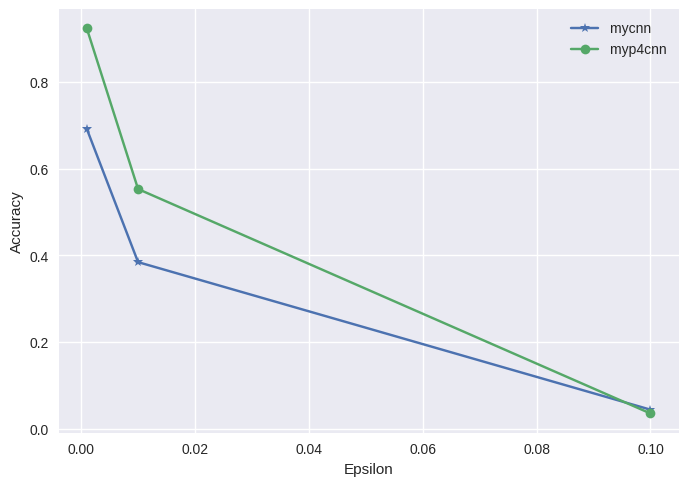

In [ ]:
plt.style.use("seaborn")
plt.plot(epsilons, accuracies_mycnn, "*-", label="mycnn")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.plot(epsilons, accuracies_myp4cnn, "o-", label="myp4cnn")
plt.legend()
plt.show()

We can observe that MyP4CNN outperforms MyCNN in defending against adversarial attacks of every variation of the epsilon value. In a dataset where very few pixels significantly influence the accurate classification of the plant leaf, both models exhibit poor performance as the perturbation becomes more visible (starting from 0.1)

As observed in CIFAR, in RGB images even very small perturbations generated with small values of epsilon, like 0.1, result in highly distorted images, making it difficult even for a human to correctly classify the perturbed leaves.

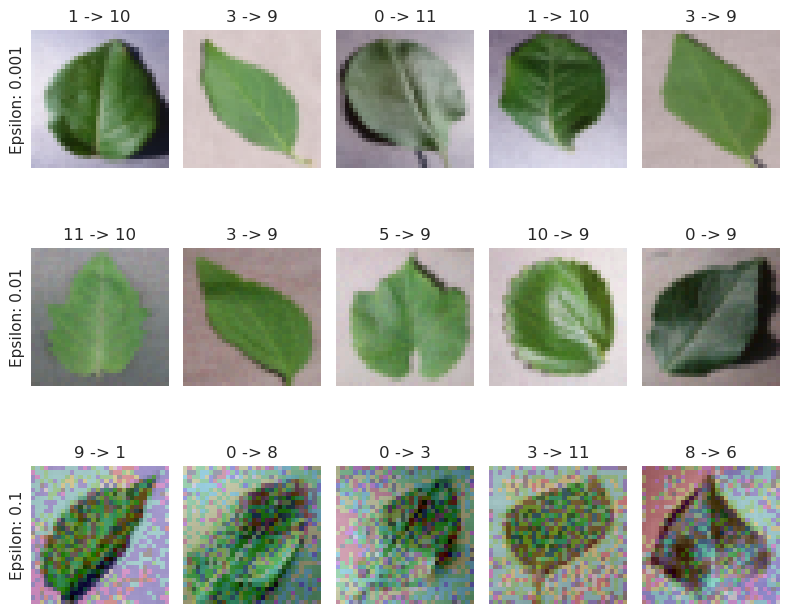

In [ ]:
def clean_axis(axis):
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xticklabels([])
    axis.set_yticklabels([])

nrows = len(epsilons)
ncols = num_display

fig, ax = plt.subplots(3, 5, figsize=(8, 7))

for row in range(nrows):
    for col in range(ncols):
        label, perturbed_pred, perturbed_image = all_adv_examples_myp4cnn[row][col]
        axis = ax[row, col]
        perturbed_image_cpu = perturbed_image.cpu()
        perturbed_image_np = perturbed_image_cpu.detach().numpy()
        perturbed_image_np = np.transpose(perturbed_image_np, (1, 2, 0))

        axis.imshow(perturbed_image_np)
        axis.set_title(f"{label} -> {perturbed_pred}")
        clean_axis(axis)
        if col == 0:
            axis.set_ylabel(f"Epsilon: {epsilons[row]}")
plt.tight_layout()
plt.show()

# **6. Conclusions**

During the experiments, the Group Equivariant Convolutional Neural Networks (G-CNNs) consistently outperformed their regular CNN counterparts. Data augmentation benefits G-CNNs just like regular convolutional networks, and perhaps even more.

To put it simply, the project's findings showed that using group convolutions is a promising way to boost the performance of convolutional neural networks while keeping their size manageable.

In addition, the experiments demonstrated that Group Equivariant Convolutional Neural Networks are generally more robust against adversarial attacks compared to simple CNNs. This is likely because they take into account the symmetries and invariances present in the data, making them less vulnerable to perturbations.

However, it's important to note that their effectiveness depends on the dataset and the type of attack used. My results are based on experiments using the Fast Gradient Sign Method (FGSM) as the only type of attack. In future works, I would like to test their robustness against other kinds of attacks.

In conclusion, while not a one-size-fits-all solution, group equivariant networks show promise in improving the robustness of deep learning systems against adversarial attacks.






